In [65]:
# Standard library imports
import os
import random
import warnings

# Third-party library imports for data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
import umap

# Machine Learning and statistical testing libraries
from scipy.stats import mannwhitneyu, f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import FitFailedWarning
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Survival analysis libraries
import sksurv
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, integrated_brier_score
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv

# Feature selection libraries
from boruta import BorutaPy
from lifelines import CoxPHFitter
# Lifelines for additional survival analysis
from lifelines.statistics import logrank_test, multivariate_logrank_test
from tqdm import tqdm
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import seaborn as sns
import umap
from dcurves import dca, plot_graphs

### Helper code

In [97]:
def calculate_survival_benefit(data_df1, data_df2, time_points=[1,3, 5,7, 10]):
    # Initialize Kaplan-Meier fitters for each group
    kmf_hr = KaplanMeierFitter()  # High risk group
    kmf_lr = KaplanMeierFitter()  # Low risk group

    # Fit data for high risk group
    kmf_hr.fit(data_df1['time'], event_observed=data_df1['event'])

    # Fit data for low risk group
    kmf_lr.fit(data_df2['time'], event_observed=data_df2['event'])

    # Calculate survival probabilities at specified time points
    survival_hr = kmf_hr.survival_function_.reindex(time_points, method='nearest')
    survival_lr = kmf_lr.survival_function_.reindex(time_points, method='nearest')

    # Calculate differences in survival probabilities and format them
    survival_benefits = {}
    for t in time_points:
        prob_hr = kmf_hr.predict(t)
        prob_lr = kmf_lr.predict(t)
        survival_benefit = (prob_lr - prob_hr) * 100  # in percentage points
        survival_benefits[t] = survival_benefit

    return survival_benefits


def plot_km_same_risk_group(data_df1, data_df2, data_stats, figure_save_path, title_str):
    
    # Create a colormap
    cmap = plt.cm.get_cmap('Reds')
    # Choose a shade of red
    hr_shade = cmap(0.75)

    cmap = plt.cm.get_cmap('Blues')
    # Choose a shade of red
    lr_shade = cmap(0.75)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    data_high_risk = data_df1
    data_low_risk = data_df2

    kmf_hr = KaplanMeierFitter()
    kmf_hr.fit(data_high_risk['time'], event_observed=data_high_risk['event'], label='RT+ADT')
    kmf_hr.plot_survival_function(ax=ax, color='#f8766d', lw=2, show_censors=True)

    kmf_lr = KaplanMeierFitter()
    kmf_lr.fit(data_low_risk['time'], event_observed=data_low_risk['event'], label='RT+ADT+CT')
    kmf_lr.plot_survival_function(ax=ax, color='#03bfc4', lw=2, show_censors=True, )
    
    
    print("Low risk median survival time: ",kmf_lr.median_survival_time_)
    print("High risk median survival time: ",kmf_hr.median_survival_time_)
    max_median_survival_time = max(kmf_hr.median_survival_time_ , kmf_lr.median_survival_time_)
    if max_median_survival_time == np.inf:
        plt.axhline(y=0.5, color='black', linestyle='--', lw=1)
    else:
        plt.plot([0, max_median_survival_time], [0.5, 0.5], color='black', linestyle='--', lw=1)
    # Vertical lines up to y=0.5, using plot for precise control
    plt.plot([kmf_hr.median_survival_time_, kmf_hr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    plt.plot([kmf_lr.median_survival_time_, kmf_lr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    ax.set_title(title_str, fontsize=26)

    yticks = [np.round(x,1) for x in ax.get_yticks()]
    ax.set_yticklabels(yticks, fontsize=20)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)


    ax.set_xlabel('Time (Years)', fontsize=28)
    ax.set_ylabel('Overall Survival Probability', fontsize=28)
    data_p, data_hr, data_ci_lower, data_ci_upper = data_stats
    format_p = lambda p: f"{p:.1e}" if p < 0.001 else f"{p:.4f}"

# Updated string formatting
    data_stats_text = f'p: {format_p(data_p)}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    #data_stats_text = f'p: {data_p:.1e if data_p < 0.001 else data_p:.4f}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    ax.text(0.03, 0.1, data_stats_text, transform=ax.transAxes, fontsize=24, verticalalignment='bottom')

    # Add the risk table at the bottom of the KM plot on ax[1] (the bottom subplot)
    sns.despine()
    add_at_risk_counts(kmf_hr, kmf_lr, ax=ax, fontsize=20)
    ax.legend(fontsize=24)
    plt.tight_layout()
    
    #fig.savefig(figure_save_path, bbox_inches='tight')
    plt.show()

def plot_km_curve_lifelines(data_df, data_stats, figure_save_path, title_str):
    
    # Create a colormap
    cmap = plt.cm.get_cmap('Reds')
    # Choose a shade of red
    hr_shade = cmap(0.75)

    cmap = plt.cm.get_cmap('Blues')
    # Choose a shade of red
    lr_shade = cmap(0.75)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    data_high_risk = data_df[data_df['risk_group']==1]
    data_low_risk = data_df[data_df['risk_group']==0]

    kmf_hr = KaplanMeierFitter()
    kmf_hr.fit(data_high_risk['time'], event_observed=data_high_risk['event'], label='High Risk')
    kmf_hr.plot_survival_function(ax=ax, color='#f8766d', lw=2, show_censors=True)

    kmf_lr = KaplanMeierFitter()
    kmf_lr.fit(data_low_risk['time'], event_observed=data_low_risk['event'], label='Low Risk')
    kmf_lr.plot_survival_function(ax=ax, color='#03bfc4', lw=2, show_censors=True, )
    
    
    print("Low risk median survival time: ",kmf_lr.median_survival_time_)
    print("High risk median survival time: ",kmf_hr.median_survival_time_)
    max_median_survival_time = max(kmf_hr.median_survival_time_ , kmf_lr.median_survival_time_)
    if max_median_survival_time == np.inf:
        plt.axhline(y=0.5, color='black', linestyle='--', lw=1)
    else:
        plt.plot([0, max_median_survival_time], [0.5, 0.5], color='black', linestyle='--', lw=1)
    # Vertical lines up to y=0.5, using plot for precise control
    plt.plot([kmf_hr.median_survival_time_, kmf_hr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    plt.plot([kmf_lr.median_survival_time_, kmf_lr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    ax.set_title(title_str, fontsize=26)

    yticks = [np.round(x,1) for x in ax.get_yticks()]
    ax.set_yticklabels(yticks, fontsize=20)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)


    ax.set_xlabel('Time (Years)', fontsize=28)
    ax.set_ylabel('Overall Survival Probability', fontsize=28)
    data_p, data_hr, data_ci_lower, data_ci_upper = data_stats
    format_p = lambda p: f"{p:.1e}" if p < 0.001 else f"{p:.4f}"

# Updated string formatting
    data_stats_text = f'p: {format_p(data_p)}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    #data_stats_text = f'p: {data_p:.1e if data_p < 0.001 else data_p:.4f}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    ax.text(0.03, 0.1, data_stats_text, transform=ax.transAxes, fontsize=24, verticalalignment='bottom')

    # Add the risk table at the bottom of the KM plot on ax[1] (the bottom subplot)
    sns.despine()
    add_at_risk_counts(kmf_hr, kmf_lr, ax=ax, fontsize=20)
    ax.legend(fontsize=24)
    plt.tight_layout()
    
    #fig.savefig(figure_save_path, bbox_inches='tight')
    plt.show()


def remove_correlated_features(df, threshold=0.95):
    # Create correlation matrix
    corr_matrix = pd.DataFrame(np.corrcoef(df.values, rowvar=False), columns=df.columns).abs() 

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    # len(to_drop)

    # Drop features 
    corr_removed_df = df.drop(to_drop, axis=1)
    
    return corr_removed_df


def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    
def boruta_selected_features(feature_df, y):
    # define Boruta feature selection method
    # ipdb.set_trace()
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    feat_selector = BorutaPy(rf, n_estimators='auto', perc=95, alpha=0.05, two_step=False,verbose=0, random_state=42)

    feat_selector.fit(feature_df.values, y)

    # check selected features
    boruta_selected_features = feature_df.columns[feat_selector.support_  | feat_selector.support_weak_].to_list()
    boruta_selected_features_df = feature_df[boruta_selected_features]
    
    return boruta_selected_features_df

def get_discriminative_features(view_features):

    view_features_trim1 = view_features.drop(['patient_id', 'event', 'time'], axis=1) #'view', , 'img_id'
    y = view_features['event']
    if scaler_type == "minmax":
        scaler = MinMaxScaler() #StandardScaler() #RobustScaler() #
    else:
        scaler = RobustScaler(unit_variance=True)
    view_features_scaled = pd.DataFrame(scaler.fit_transform(view_features_trim1.values), columns=view_features_trim1.columns)

    view_features_trim2 = remove_correlated_features(view_features_scaled, threshold=0.85)


    # drop columns with zero variance using sklearn's VarianceThreshold
    sel = VarianceThreshold(threshold=0.01)
    sel.fit(view_features_trim2)
    view_features_trimmed = view_features_trim2[view_features_trim2.columns[sel.get_support(indices=True)]]
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    feat_selector = BorutaPy(rf, n_estimators='auto', perc=98, alpha=0.05, two_step=False,verbose=0, random_state=42)

    feat_selector.fit(view_features_trimmed.values, y)


    # check selected features
    boruta_selected_features = view_features_trimmed.columns[feat_selector.support_].to_list() # | feat_selector.support_weak_

    disc_features = view_features_trimmed[boruta_selected_features]
    disc_features = pd.DataFrame(scaler.fit_transform(disc_features.values), columns=disc_features.columns)

    return disc_features#, sig_pvals

def plot_raincloudplots(df, stable_features, events_df, save_path):
    rc_plot_df = df.copy()
    rc_plot_df['event'] = events_df
    for feature in stable_features:
        fig = plt.figure(figsize=(5,4))
        # Perform wilcoxon test to check if the feature is significantly different between the two groups
        
        stat, pvalue = f_oneway(rc_plot_df[events_df==1][feature].values, rc_plot_df[events_df==0][feature].values)
        
        pt.RainCloud(x='event', y=feature, data=rc_plot_df)
        plt.title('p_val: '+str(pvalue))
        plt.show()
        fig.savefig(save_path+'_'+feature+'.png', dpi=300, bbox_inches='tight')
        
def get_hr_and_pval(threshold, val_risk_scores, y_val_survlabel):

    # Calculate Kaplan-Meier estimator for different risk groups
    risk_groups = threshold #np.mean(val_risk_scores)#np.percentile(test_risk_scores, 50)
    risk_group_labels = np.array([1 if x > risk_groups else 0 for x in val_risk_scores])#np.digitize(test_risk_scores, risk_groups)
    survival_probs = []
    survival_times = []

    for group_label in np.unique(risk_group_labels):
        group_indices = np.where(risk_group_labels == group_label)
        group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
        survival_probs.append(group_survival_prob)
        survival_times.append(group_time)


    tstat, pval, stats0, stats1 = compare_survival(y_val_survlabel, risk_group_labels, return_stats=True)

    return tstat, pval

def get_cph_model_stats(cph_model_results, c_index):
    
    cph_p_value = cph_model_results['p'].values[0]
    cph_HR = cph_model_results['exp(coef)'].values[0]
    cph_CI_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    cph_CI_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    
    
    return (cph_p_value, cph_HR, cph_CI_lower, cph_CI_upper, c_index)

def get_multivariate_coxph_results(risk_df, drop_cols=['patient_id']):
    
    cph = CoxPHFitter(l1_ratio=0.7)
    risk_vars = risk_df.drop(columns=drop_cols)
    cph.fit(risk_vars, duration_col='time', event_col='event', show_progress=False)
    results = cph.summary
    
    return results, cph

def get_multivariate_coxph_results_stratified(risk_df, drop_cols=['patient_id'], strata_cols=['gleason']):
    # Initialize the Cox proportional hazards model with regularization
    cph = CoxPHFitter(l1_ratio=0.7)
    
    # Drop specified columns from the DataFrame
    risk_vars = risk_df.drop(columns=drop_cols)
    
    # Fit the model with stratification on the specified columns
    cph.fit(risk_vars, duration_col='time', event_col='event', strata=strata_cols, show_progress=False)
    
    # Get the summary of the model's results
    results = cph.summary
    
    return results, cph

def plot_n_save_adjusted_hazard(cph_training_adjusted_risk, cph_holdout_adjusted_risk,training_df, holdout_df, save_path, title='Adjusted Risk model'):
    
    fig, ax = plt.subplots(1, 2, figsize=(25,10))

    cph_training_adjusted_risk.plot(hazard_ratios=True, ax = ax[0])
    ax[0].set_title('Training Patients', fontsize=23)
    ax[0].set_ylabel('Covariates', fontsize=20)
    ax[0].set_xlabel('Hazard Ratio (95% CI)', fontsize=18)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=18)
    ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=18)
    
    # increase the space between the two subplots
    fig.subplots_adjust(wspace=0.5)
    
    cph_holdout_adjusted_risk.plot(hazard_ratios=True, ax = ax[1])
    ax[1].set_title('Holdout Patients'.format(len(holdout_df)), fontsize=20)

    
    ax[1].set_xlabel('Hazard Ratio (95% CI)', fontsize=18)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=18)
    ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=18)

    plt.suptitle(title, fontsize=25, y=0.98)
    #fig.savefig(save_path)
    plt.show()

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
# nucdiv_features_train = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\data\combined_spatil_nucdiv\nucdiv_features_train_selected.csv")
# nucdiv_features_test = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\data\combined_spatil_nucdiv\nucdiv_features_test_selected.csv")
# spatil_features_train = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\data\combined_spatil_nucdiv\spatil_features_train_selected.csv")
# spatil_features_test = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\data\combined_spatil_nucdiv\spatil_features_test_selected.csv")
# features.drop(columns=['time'], inplace=True)
# clinical = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\scripts\RTOG_0521_clinical_data_scripts\RTOG_0521_clinical_data.csv")
# # nucdiv_features = pd.concat([nucdiv_features_train, nucdiv_features_test], axis=0)
# spatil_features = pd.concat([spatil_features_train, spatil_features_test], axis=0)
# # nucdiv_features.columns = ['nucdiv_' + str(col) for col in nucdiv_features.columns]
# # nucdiv_features = nucdiv_features.rename(columns={'nucdiv_patient_id': 'patient_id'})
# # spatil_features.columns = ['spatil_' + str(col) for col in spatil_features.columns]
# # spatil_features = spatil_features.rename(columns={'spatil_patient_id': 'patient_id'})
# # features = pd.merge(nucdiv_features, spatil_features, on='patient_id', how='inner')
# # features.drop(columns=['spatil_event', 'spatil_time', 'spatil_chemo', 'spatil_umap_x', 'spatil_umap_y', 'nucdiv_umap_x', 'nucdiv_umap_y', 'nucdiv_chemo', 'nucdiv_risk_score', 'nucdiv_risk_group','spatil_risk_score',
# #        'spatil_risk_group'], inplace=True)
# # features.rename(columns={'nucdiv_event': 'event', 'nucdiv_time': 'time'}, inplace=True)
# clinical.rename(columns={'cn_deidentified': 'patient_id'}, inplace=True)
# features = pd.merge(features, clinical[['patient_id', 'survival_years']], on='patient_id', how='inner')
# features.rename(columns={'survival_years': 'time'}, inplace=True)
# features = pd.merge(features, spatil_features[['patient_id', 'risk_group']], on='patient_id', how='inner')

### Survival Analysis

In [4]:
features = pd.read_csv(r"/Users/srmedinac/Library/CloudStorage/OneDrive-EmoryUniversity/Documents/data/combined_spatil_nucdiv/combined_fixed_final.csv")

In [5]:
features

,patient_id,spatil_341,spatil_0,spatil_198,spatil_115,spatil_117,spatil_1,spatil_196,spatil_137,spatil_86,...,survival_years,disease_free_survival,disease_free_survival_years,any_distant_mets,any_distant_mets_years,local_failure,local_failure_years,biochemical_failure,biochemical_failure_years,RX
0,0521-237186,0.000949,2.313596,0.040449,0.076989,0.077100,616639.8217,0.001183,-0.458767,0.049075,...,12.569863,1,11.515068,0,12.569863,2,11.515068,1,11.515068,2
1,0521-972417,0.000230,0.589928,0.014388,0.122302,0.079137,505414.6437,0.000000,-0.736258,0.037996,...,12.673973,1,3.676712,1,3.838356,2,3.676712,1,3.676712,2
2,0521-641497,0.000487,2.381323,0.040962,0.065492,0.053160,627747.8018,0.022110,NaN,0.063769,...,12.783562,1,5.586301,1,5.586301,2,5.586301,2,5.586301,1
3,0521-650593,0.000363,0.906250,0.000000,0.187500,0.015625,387458.5295,0.000000,-0.585565,0.041645,...,5.682192,1,5.682192,2,5.682192,2,5.682192,2,5.682192,1
4,0521-931689,0.001446,3.090164,0.081967,0.024590,0.077869,761431.0205,0.000000,0.117851,0.041437,...,12.468493,0,12.468493,0,12.468493,0,12.468493,0,12.468493,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0521-785941,0.000732,3.281046,0.065359,0.000000,0.133987,828746.7572,0.006536,0.072355,0.111350,...,9.619178,0,9.619178,0,9.619178,0,9.619178,0,9.619178,1
346,0521-227777,0.001024,3.107306,0.052511,0.027397,0.092466,742567.9167,0.006849,-0.219583,0.078424,...,9.731507,0,9.731507,0,9.731507,0,9.731507,0,9.731507,2
347,0521-225186,0.001610,3.624242,0.042424,0.018182,0.084848,694474.1551,0.006061,-0.192190,0.103269,...,4.794521,1,4.794521,2,4.794521,2,4.794521,2,4.794521,1
348,0521-601511,0.000279,1.300000,0.093750,0.025000,0.275000,848550.0244,0.000000,-0.707107,0.000000,...,7.690411,1,7.690411,2,7.690411,2,7.690411,2,7.690411,2


In [6]:
# drop all features that start with nucdiv_
# features = features.drop(columns=[col for col in features.columns if col.startswith('nucdiv_')])
features.rename(columns={'survival_years': 'time', 'survival': 'event'}, inplace=True)
features = features.drop(columns=['disease_free_survival', 'disease_free_survival_years', 'any_distant_mets', 'any_distant_mets_years', 'local_failure', 'local_failure_years', 'biochemical_failure', 'biochemical_failure_years'])

In [7]:
features

,patient_id,spatil_341,spatil_0,spatil_198,spatil_115,spatil_117,spatil_1,spatil_196,spatil_137,spatil_86,...,nucdiv_360,nucdiv_18,nucdiv_1246,nucdiv_1720,nucdiv_2131,nucdiv_293,nucdiv_2046,event,time,RX
0,0521-237186,0.000949,2.313596,0.040449,0.076989,0.077100,616639.8217,0.001183,-0.458767,0.049075,...,21.351095,0.150225,2.173635,10.058394,0.271796,0.544727,0.078474,0,12.569863,2
1,0521-972417,0.000230,0.589928,0.014388,0.122302,0.079137,505414.6437,0.000000,-0.736258,0.037996,...,28.050408,0.077229,2.222222,4.700487,0.222222,0.564670,0.084913,0,12.673973,2
2,0521-641497,0.000487,2.381323,0.040962,0.065492,0.053160,627747.8018,0.022110,NaN,0.063769,...,15.270753,0.092709,2.000000,35.447978,0.200302,0.564203,0.107131,0,12.783562,1
3,0521-650593,0.000363,0.906250,0.000000,0.187500,0.015625,387458.5295,0.000000,-0.585565,0.041645,...,3.859179,0.025633,2.000000,3.044537,0.160000,0.634821,0.100000,1,5.682192,1
4,0521-931689,0.001446,3.090164,0.081967,0.024590,0.077869,761431.0205,0.000000,0.117851,0.041437,...,37.041024,0.077692,2.000000,14.729458,0.222222,0.500000,0.090909,0,12.468493,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0521-785941,0.000732,3.281046,0.065359,0.000000,0.133987,828746.7572,0.006536,0.072355,0.111350,...,13.084241,0.165747,2.000000,11.063565,0.247327,0.527987,0.082873,0,9.619178,1
346,0521-227777,0.001024,3.107306,0.052511,0.027397,0.092466,742567.9167,0.006849,-0.219583,0.078424,...,41.229004,0.109228,2.000000,12.902779,0.198347,0.611852,0.100000,0,9.731507,2
347,0521-225186,0.001610,3.624242,0.042424,0.018182,0.084848,694474.1551,0.006061,-0.192190,0.103269,...,7.114129,0.068559,1.944444,6.984021,0.222222,0.607143,0.093169,1,4.794521,1
348,0521-601511,0.000279,1.300000,0.093750,0.025000,0.275000,848550.0244,0.000000,-0.707107,0.000000,...,34.355417,0.090418,1.923077,20.819353,0.222222,0.644298,0.095238,1,7.690411,2


In [8]:
split_percentage = 0.5
scaler_type = "minmax" # "robust"
feature_Sel_type = "ElasticNet"
cohort = "RTOG_0521_OS_spatil_plus_nucdiv"
l1_ratio = 0.9
risk_treshold_method = "median"
num_features = 5
N_runs = 50
seed = 0
random.seed(seed)

In [9]:
imputer = SimpleImputer(strategy='median')
rtog_features = features.drop(['patient_id', 'RX', 'time', 'event'], axis=1) # 
rtog_features.replace([np.inf, -np.inf], np.nan, inplace=True)
num_df = rtog_features.values
names = rtog_features.columns.values
rtog_features = pd.DataFrame(imputer.fit_transform(num_df), columns=names)
rtog_features['patient_id'] = features['patient_id']
rtog_features['RX'] = features['RX']
rtog_features['time'] = features['time']
rtog_features['event'] = features['event']


##### Select one treatment arm to train

In [10]:
rtog_leg_1 = rtog_features.loc[rtog_features['RX'] == 1]

#### Bootstrapping

In [11]:
training_data, holdout_data = train_test_split(rtog_leg_1, test_size=split_percentage, random_state=42, stratify=rtog_leg_1['event'])
random_numbers = [random.randint(0, 1000) for _ in range(N_runs)]
bootstrap_metrics = pd.DataFrame()
print("Running {} iterations".format(N_runs))

for i in tqdm(range(N_runs)):

    random_seed = random_numbers[i]
    train_data, val_data = train_test_split(training_data, test_size=split_percentage, random_state=random_seed, stratify=training_data['event'])
    X_train = train_data.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
    y_train = train_data[['patient_id','event', 'time']].reset_index(drop=True)
    X_val = val_data.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
    y_val = val_data[['patient_id','event', 'time']].reset_index(drop=True)
    if scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = RobustScaler(unit_variance=True)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    varTh = VarianceThreshold(threshold=0.05)
    varTh.fit(X_train)
    X_train = X_train[X_train.columns[varTh.get_support(indices=True)]]
    X_val = X_val[X_val.columns[varTh.get_support(indices=True)]]
    X_train_decorrelated = remove_correlated_features(X_train, 0.8)
    X_train_trimmed = X_train_decorrelated.copy()
    X_val_trimmed = X_val[X_train_trimmed.columns]
    print(f"Training features input to ElasticNet model (l1={l1_ratio}) = {X_train_trimmed.shape}")
    y_train_survlabel = Surv.from_dataframe('event', 'time', y_train)
    y_val_survlabel = Surv.from_dataframe('event', 'time', y_val)

    try:
        coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, alpha_min_ratio=0.01, max_iter=20, fit_baseline_model=True))
        warnings.simplefilter("ignore", UserWarning)
        warnings.simplefilter("ignore", FitFailedWarning)
        coxnet_pipe.fit(X_train_trimmed, y_train_survlabel)
        estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        gcv = GridSearchCV(
        make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, fit_baseline_model=True)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=1,
        ).fit(X_train_trimmed, y_train_survlabel)
        cv_results = pd.DataFrame(gcv.cv_results_)
        alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
        mean = cv_results.mean_test_score
        std = cv_results.std_test_score
        best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
        best_coefs = pd.DataFrame(best_model.coef_, index=X_train_trimmed.columns, columns=["coefficient"])
        non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
        non_zero_coefs = best_coefs.query("coefficient != 0")
        coef_order = non_zero_coefs.abs().sort_values("coefficient").index
        print("Number of non-zero features: {}".format(non_zero))
        coxnet_pred = gcv.best_estimator_
        C_test = coxnet_pred.score(X_val_trimmed, y_val_survlabel)
        print('C-index on test set: {:.3f}'.format(C_test))
        val_risk_scores = coxnet_pred.predict(X_val_trimmed)
        events, times = y_val['event'].values.astype(bool), y_val['time'].values
        coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
        hr_median, pval_median = get_hr_and_pval(np.median(val_risk_scores), val_risk_scores, y_val_survlabel)
        hr_mean, pval_mean = get_hr_and_pval(np.mean(val_risk_scores), val_risk_scores, y_val_survlabel)
        temp_dict = {'Seed': [random_seed], 'Test_Cindex': [C_test], 'Test_pval_mean': [pval_mean], 'Hazard_ratio_mean': [hr_mean], 'Test_pval_median': [pval_median], 'Hazard_ratio_median': [hr_median], 'Nonzero_features_count': [non_zero]}
        temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
        temp_df['Nonzero_features']= [coef_order.values.tolist()]
        temp_df['Nonzero_features_coefs']= [non_zero_coefs['coefficient'].values.tolist()]
        bootstrap_metrics = pd.concat([bootstrap_metrics, temp_df], axis=0, ignore_index=True)
    except Exception as e:
        print("Iteration {} failed".format(i+1))
        print("Retrying iteration {}...".format(i+1))
        print(e)
        i=i-1
        continue
    

Running 50 iterations


  0%|          | 0/50 [00:00<?, ?it/s]

Training features input to ElasticNet model (l1=0.9) = (82, 20)


  2%|▏         | 1/50 [00:00<00:31,  1.54it/s]

Number of non-zero features: 4
C-index on test set: 0.368
Training features input to ElasticNet model (l1=0.9) = (82, 19)


  4%|▍         | 2/50 [00:01<00:31,  1.52it/s]

Number of non-zero features: 1
C-index on test set: 0.218
Training features input to ElasticNet model (l1=0.9) = (82, 19)


  6%|▌         | 3/50 [00:02<00:31,  1.48it/s]

Number of non-zero features: 2
C-index on test set: 0.401
Training features input to ElasticNet model (l1=0.9) = (82, 22)


  8%|▊         | 4/50 [00:02<00:32,  1.40it/s]

Number of non-zero features: 4
C-index on test set: 0.321
Training features input to ElasticNet model (l1=0.9) = (82, 21)


KeyboardInterrupt: 

In [76]:
bootstrap_metrics

,Seed,Test_Cindex,Test_pval_mean,Hazard_ratio_mean,Test_pval_median,Hazard_ratio_median,Nonzero_features_count,Nonzero_features,Nonzero_features_coefs
0,864,0.548035,0.574456,0.315283,0.489802,0.476962,23,"[spatil_336, nucdiv_833, nucdiv_870, nucdiv_14...","[11.22333387110792, -10.844091249404514, -6.61..."
1,394,0.432432,0.572383,0.318711,0.572383,0.318711,7,"[nucdiv_1452, nucdiv_1246, spatil_0, spatil_32...","[-0.3418632778583298, -0.5090906508798482, -0...."
2,776,0.609544,0.907349,0.013545,0.166019,1.918530,23,"[spatil_86, nucdiv_2896, nucdiv_1248, nucdiv_1...","[-18.47919382701862, 2.281883565976666, 5.5476..."
3,911,0.358163,0.167138,1.908426,0.103985,2.643343,1,[spatil_341],[0.49038903387134664]
4,430,0.407080,0.318534,0.994958,0.318534,0.994958,16,"[nucdiv_833, spatil_198, spatil_344, spatil_19...","[0.33247108223406524, 0.13015848962975582, -0...."
5,41,0.627792,0.205019,1.606256,0.205019,1.606256,25,"[spatil_86, nucdiv_1452, nucdiv_833, nucdiv_19...","[4.607481733692557, -15.144039208741896, 6.323..."
6,265,0.608511,0.762959,0.090961,0.132756,2.259981,20,"[nucdiv_833, nucdiv_1248, spatil_198, nucdiv_2...","[-1.5572461675097098, 0.14752370534383846, -3...."
7,988,0.533482,0.868997,0.027203,0.438502,0.600198,1,[nucdiv_1992],[0.32970086607435223]
8,523,0.547170,0.379534,0.772211,0.992645,0.000085,1,[nucdiv_60],[-0.07683923414803878]
9,497,0.566810,0.020559,5.363827,0.038745,4.272007,14,"[nucdiv_2046, nucdiv_2896, spatil_344, nucdiv_...","[1.8255638353821835, 1.3172757275261553, -1.49..."


##### Calculating feature frequency during bootstrapping

In [77]:
feature_frequency_dict = {}
feature_coefficient_strength_dict = {}
for feature_list in bootstrap_metrics['Nonzero_features']:
    list_idx = bootstrap_metrics['Nonzero_features'].values.tolist().index(feature_list)
    for feature in feature_list:
        idx = feature_list.index(feature)
        feat_coef = np.abs(bootstrap_metrics['Nonzero_features_coefs'][list_idx][idx])
        
        if feature in feature_frequency_dict:
            feature_frequency_dict[feature] += 1
        else:
            feature_frequency_dict[feature] = 1
        
        if feature in feature_coefficient_strength_dict:
            feature_coefficient_strength_dict[feature] += feat_coef
        else:
            feature_coefficient_strength_dict[feature] = feat_coef
print(feature_frequency_dict)
print(feature_coefficient_strength_dict)
feature_frequency = pd.DataFrame(feature_frequency_dict.items(), columns=['feature', 'count'])
feature_coefs = pd.DataFrame(feature_coefficient_strength_dict.items(), columns=['feature', 'coefficient'])
feature_frequency = feature_frequency.merge(feature_coefs, on='feature', how='left')
feature_frequency = feature_frequency.sort_values(by='coefficient', ascending=False).reset_index(drop=True)
feature_frequency['feature_score'] = feature_frequency['count'] * feature_frequency['coefficient']/N_runs
feature_frequency = feature_frequency.sort_values(by='feature_score', ascending=False).reset_index(drop=True)
feature_frequency

{'spatil_336': 14, 'nucdiv_833': 31, 'nucdiv_870': 27, 'nucdiv_1452': 33, 'nucdiv_60': 39, 'nucdiv_293': 32, 'spatil_131': 19, 'spatil_117': 28, 'nucdiv_2131': 26, 'spatil_344': 21, 'nucdiv_360': 28, 'spatil_86': 30, 'nucdiv_1248': 27, 'nucdiv_18': 32, 'nucdiv_1246': 33, 'nucdiv_2896': 27, 'nucdiv_1720': 30, 'spatil_196': 27, 'spatil_198': 29, 'nucdiv_2046': 30, 'nucdiv_1992': 28, 'spatil_0': 17, 'spatil_341': 25, 'spatil_327': 13, 'nucdiv_2095': 30, 'spatil_115': 21, 'spatil_1': 22, 'spatil_51': 14, 'spatil_338': 6, 'spatil_137': 26}
{'spatil_336': 220.59687802305143, 'nucdiv_833': 383.3561761274908, 'nucdiv_870': 260.29670246184827, 'nucdiv_1452': 134.3253478578719, 'nucdiv_60': 280.46394180425614, 'nucdiv_293': 226.15495238238842, 'spatil_131': 96.33104550322803, 'spatil_117': 462.03200475014097, 'nucdiv_2131': 382.0577702357935, 'spatil_344': 56.70972685024132, 'nucdiv_360': 249.32939567860518, 'spatil_86': 313.89302489429195, 'nucdiv_1248': 266.7264137325605, 'nucdiv_18': 187.7366

,feature,count,coefficient,feature_score
0,spatil_117,28,462.032005,258.737923
1,nucdiv_833,31,383.356176,237.680829
2,nucdiv_60,39,280.463942,218.761875
3,nucdiv_1720,30,341.605358,204.963215
4,nucdiv_2131,26,382.057770,198.670041
5,spatil_86,30,313.893025,188.335815
6,nucdiv_2095,30,292.573237,175.543942
7,nucdiv_293,32,226.154952,144.739170
8,nucdiv_1248,27,266.726414,144.032263
9,nucdiv_1246,33,214.974580,141.883222


##### Feature importance

In [78]:

train_df = training_data[feature_frequency['feature'][:num_features].values]
holdout_df = holdout_data[feature_frequency['feature'][:num_features].values]
X_training = train_df.reset_index(drop=True)
y_training = training_data[['patient_id','event', 'time']].reset_index(drop=True)
X_holdout = holdout_df.reset_index(drop=True)
y_holdout = holdout_data[['patient_id','event', 'time']].reset_index(drop=True)
if scaler_type == "minmax":
    second_scaler = MinMaxScaler()
else:
    second_scaler = RobustScaler(unit_variance=True)
X_training = pd.DataFrame(second_scaler.fit_transform(X_training), columns=X_training.columns)
X_holdout = pd.DataFrame(second_scaler.transform(X_holdout), columns=X_holdout.columns)
varTh = VarianceThreshold(threshold=0.01)
varTh.fit(X_training)
X_training = X_training[X_training.columns[varTh.get_support(indices=True)]]
X_holdout = X_holdout[X_holdout.columns[varTh.get_support(indices=True)]]
X_training_trimmed = remove_correlated_features(X_training, 1)
X_holdout_trimmed = X_holdout[X_training_trimmed.columns]
print("Training data: {}".format(X_training_trimmed.shape))
print("Testing data: {}".format(X_holdout_trimmed.shape))

Training data: (84, 5)
Testing data: (85, 5)


In [79]:
y_training_survlabel = Surv.from_dataframe('event', 'time', y_training)
y_holdout_survlabel = Surv.from_dataframe('event', 'time', y_holdout)

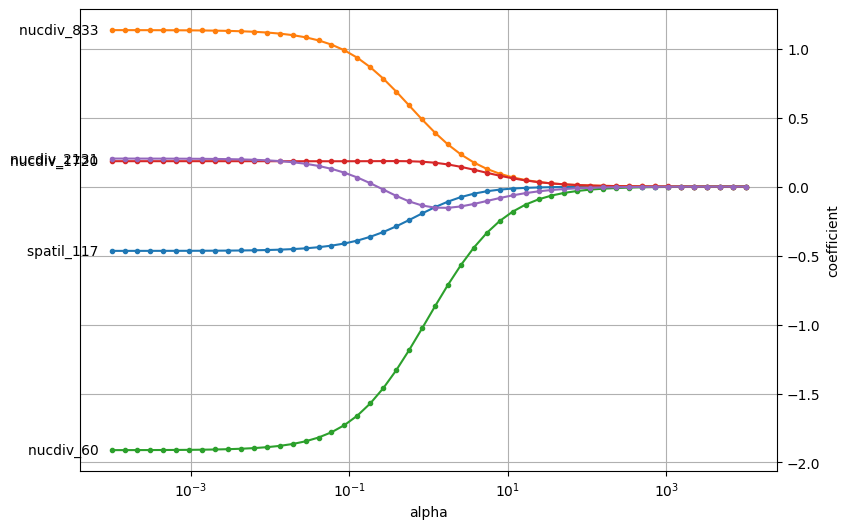

In [80]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_training_trimmed, y_training_survlabel)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(X_training_trimmed.columns)
plot_coefficients(coefficients, n_highlight=6)

#### Build CoxNet CV with selected features

In [81]:
coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, max_iter=50, fit_baseline_model=True))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_training_trimmed, y_training_survlabel)

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
param_grid = {
    #'coxnetsurvivalanalysis__l1_ratio': np.linspace(0.1, 0.9, 18),  # Explore l1_ratio between 0.1 and 0.9
    'coxnetsurvivalanalysis__alphas': [[alpha] for alpha in estimated_alphas]  # Use estimated alphas
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, fit_baseline_model=True)),
    param_grid=param_grid,
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(X_training_trimmed, y_training_survlabel)

cv_results = pd.DataFrame(gcv.cv_results_)
print(f"Best parameters found: {gcv.best_params_}")
print(cv_results[['mean_test_score', 'std_test_score']])

Best parameters found: {'coxnetsurvivalanalysis__alphas': [0.004486817279269219]}
    mean_test_score  std_test_score
0          0.500000        0.000000
1          0.500000        0.000000
2          0.500000        0.000000
3          0.500000        0.000000
4          0.500000        0.000000
..              ...             ...
93         0.579456        0.081846
94         0.576754        0.079252
95         0.576754        0.079252
96         0.576754        0.079252
97         0.576754        0.079252

[98 rows x 2 columns]


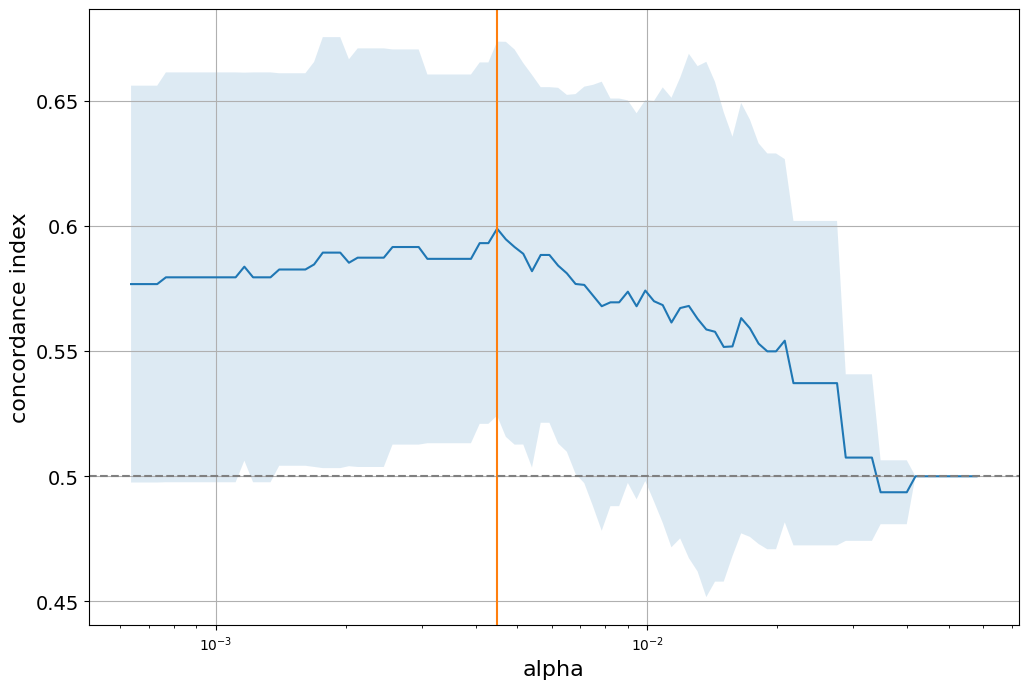

In [82]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index", fontsize=16)
ax.set_xlabel("alpha", fontsize=16)
yticks = [np.round(x,2) for x in ax.get_yticks()]
ax.set_yticklabels(yticks, fontsize=14)
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)
#fig.savefig(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/C_index_vs_alpha_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png')

##### Feature coefficients

Number of non-zero coefficients: 4


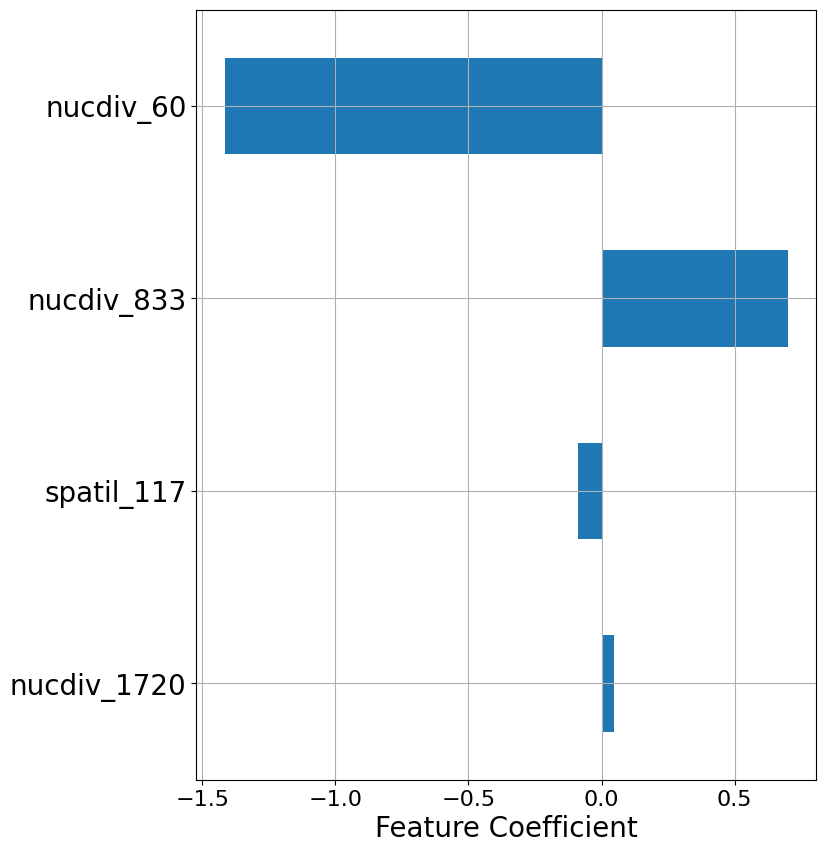

In [83]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_training_trimmed.columns, columns=["coefficient"])
non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")
non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index
fig1, ax = plt.subplots(figsize=(8,10))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("Feature Coefficient", fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=20)
ax.grid(True)
#fig1.savefig(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/TopFeatures_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png', bbox_inches="tight")

In [84]:
non_zero_coefs.index

Index(['spatil_117', 'nucdiv_833', 'nucdiv_60', 'nucdiv_1720'], dtype='object')

In [85]:
non_zero_coefs.to_dict()['coefficient']

{'spatil_117': -0.09008351515949793,
 'nucdiv_833': 0.701130795688015,
 'nucdiv_60': -1.4157075540204587,
 'nucdiv_1720': 0.044880029603684896}

In [86]:
coef_order

Index(['nucdiv_1720', 'spatil_117', 'nucdiv_833', 'nucdiv_60'], dtype='object')

##### Calculate model metrics

In [87]:
print("Metrics for model")
coxnet_pred = gcv.best_estimator_

training_prediction = coxnet_pred.predict(X_training_trimmed)
holdout_prediction = coxnet_pred.predict(X_holdout_trimmed)

training_survival = coxnet_pred.predict_survival_function(X_training_trimmed)
times_training = np.arange(int(np.min(y_training_survlabel['time'])), int(np.max(y_training_survlabel["time"])))
try:
    survival_prediction_training = np.asarray([[fn(t) for t in times_training] for fn in training_survival])
except:
    print("Error in calculating survival prediction for training set")

holdout_survival = coxnet_pred.predict_survival_function(X_holdout_trimmed)
times_holdout = np.arange(int(np.min(y_holdout_survlabel['time'])), int(np.max(y_holdout_survlabel["time"])))
try:
    survival_prediction_holdout = np.asarray([[fn(t) for t in times_holdout] for fn in holdout_survival])
except:
    print("Error in calculating survival prediction for holdout set")

c_index_training = concordance_index_censored(y_training_survlabel["event"], y_training_survlabel["time"], training_prediction)
c_index_holdout = concordance_index_censored(y_holdout_survlabel["event"], y_holdout_survlabel["time"], holdout_prediction)
print('C-index on Training set: {:.3f}'.format(c_index_training[0]))
print('C-index on Holdout set: {:.3f}'.format(c_index_holdout[0]))

# calculate the IPCW C-index for the training and holdout set
c_ipcw_training = concordance_index_ipcw(y_training_survlabel, y_training_survlabel, training_prediction)
c_ipcw_holdout = concordance_index_ipcw(y_training_survlabel, y_holdout_survlabel, holdout_prediction)
print('IPCW C-index on Training set: {:.3f}'.format(c_ipcw_training[0]))
print('IPCW C-index on Holdout set: {:.3f}'.format(c_ipcw_holdout[0]))

try:
    ibs_training = integrated_brier_score(y_training_survlabel, y_training_survlabel, survival_prediction_training, times_training)
    ibs_holdout = integrated_brier_score(y_training_survlabel, y_holdout_survlabel, survival_prediction_holdout, times_holdout)
    print('IBS on training set: {:.3f}'.format(ibs_training))
    print('IBS on Holdout set: {:.3f}'.format(ibs_holdout))
except:
    print("Error in calculating IBS")

# create a dataframe to store the model type and c-index
model_metrics = pd.DataFrame()
model_metrics['cohort'] = ["rt_arm"]
model_metrics['c_index_train'] = [c_index_training[0]]
model_metrics['c_index_holdout'] = [c_index_holdout[0]]
model_metrics['c_index_ipcw_train'] = [c_ipcw_training[0]]
model_metrics['c_index_ipcw_holdout'] = [c_ipcw_holdout[0]]
try:
    model_metrics['integrated_brier_score_train'] = [ibs_training]
    model_metrics['integrated_brier_score_holdout'] = [ibs_holdout]
except:
    model_metrics['integrated_brier_score_train'] = [0]
    model_metrics['integrated_brier_score_holdout'] = [0]



Metrics for model
C-index on Training set: 0.629
C-index on Holdout set: 0.488
IPCW C-index on Training set: 0.628
IPCW C-index on Holdout set: 0.496
Error in calculating IBS


#### Predict and stratify

In [88]:
training_risk_scores = coxnet_pred.predict(X_training_trimmed)
events, times = y_training['event'].values.astype(bool),   y_training['time'].values
coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

In [89]:
mean = np.mean(training_risk_scores)
std = np.std(training_risk_scores)
lower_bound = mean - std
upper_bound = mean + std
threshold_values = np.linspace(lower_bound, upper_bound, num=int((upper_bound - (lower_bound)) / 0.001) + 1)
p_values = []
thresholds = []

for threshold in threshold_values:
    # Assuming 'train_risk_group_labels' needs to be defined based on the current threshold
    train_risk_group_labels = np.array([1 if x > threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
    #p_values.append(multivariate_logrank_test(times, train_risk_group_labels, events).p_value)
    thresholds.append(threshold)
    p_values.append(logrank_test(times[train_risk_group_labels==0], times[train_risk_group_labels==1], events[train_risk_group_labels==0], events[train_risk_group_labels==1]).p_value)



##### Define the threshold

In [90]:
risk_threshold = np.median(training_risk_scores)

##### P values vs thresholds

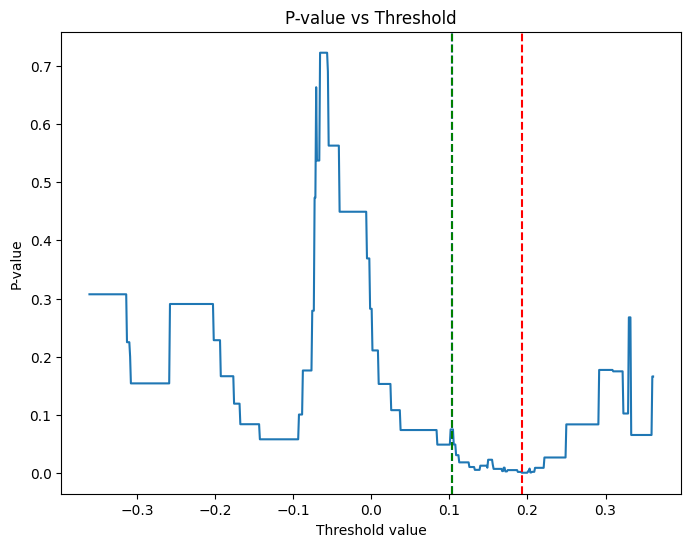

In [91]:
# plot p values vs thresholds
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, p_values)
ax.set_xlabel("Threshold value")
ax.set_ylabel("P-value")
ax.set_title("P-value vs Threshold")
#plot a red line in the minimum p-value
min_pval_idx = np.argmin(p_values)
ax.axvline(risk_threshold, color='blue', linestyle='--')
ax.axvline(thresholds[min_pval_idx], color='r', linestyle='--')
ax.axvline(np.median(training_risk_scores), color='g', linestyle='--')

In [92]:
train_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
train_survival_probs = []
train_survival_times = []

for group_label in np.unique(train_risk_group_labels):
    group_indices = np.where(train_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    train_survival_probs.append(group_survival_prob)
    train_survival_times.append(group_time)

holdout_risk_scores = coxnet_pred.predict(X_holdout_trimmed)
events, times = y_holdout['event'].values.astype(bool),   y_holdout['time'].values
coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
holdout_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in holdout_risk_scores])#np.digitize(test_risk_scores, risk_groups)
holdout_survival_probs = []
holdout_survival_times = []

for group_label in np.unique(holdout_risk_group_labels):
    group_indices = np.where(holdout_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)

In [93]:
results = logrank_test(times[holdout_risk_group_labels==0], times[holdout_risk_group_labels==1], events[holdout_risk_group_labels==0], events[holdout_risk_group_labels==1])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 1.00      0.00

In [94]:
results = multivariate_logrank_test(times, holdout_risk_group_labels, events)
results.p_value

0.9973624294158326

In [95]:
y_holdout['risk_score'] = holdout_risk_scores
y_holdout['risk_group'] = holdout_risk_group_labels
y_holdout['patient_id'] = y_holdout['patient_id']
y_holdout = y_holdout.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout

,patient_id,event,time,risk_score,risk_group
0,0521-011235,0,10.736986,0.139632,1
1,0521-029609,0,11.534247,0.086469,0
2,0521-031663,0,9.978082,0.326596,1
3,0521-032790,1,2.810959,-0.068506,0
4,0521-042494,0,12.550685,-0.429607,0
...,...,...,...,...,...
80,0521-930935,0,12.698630,-0.438490,0
81,0521-931689,0,12.468493,0.309301,1
82,0521-948904,0,4.200000,-0.187613,0
83,0521-968370,0,12.610959,-0.465236,0


In [96]:
y_training['risk_score'] = training_risk_scores
y_training['risk_group'] = train_risk_group_labels
y_training['patient_id'] = y_training['patient_id']
y_training = y_training.sort_values(by=['patient_id']).reset_index(drop=True)
y_training

,patient_id,event,time,risk_score,risk_group
0,0521-002001,0,7.111790,0.147865,1
1,0521-035384,0,9.703099,0.322279,1
2,0521-039456,1,1.936986,0.249404,1
3,0521-042918,0,10.649001,0.105167,1
4,0521-046445,0,6.528767,-0.388800,0
...,...,...,...,...,...
79,0521-934543,1,3.413699,-0.677807,0
80,0521-966640,1,3.983562,-0.415185,0
81,0521-983798,0,10.441680,0.607331,1
82,0521-989175,0,10.780844,0.366616,1


##### Calculate stats

In [97]:
LL_train = y_training.drop(['patient_id', 'risk_score'], axis=1)
LL_holdout = y_holdout.drop(['patient_id', 'risk_score'], axis=1)
cph_train = CoxPHFitter()
cph_train.fit(LL_train, duration_col='time', event_col='event', show_progress=False)
cph_holdout = CoxPHFitter()
cph_holdout.fit(LL_holdout, duration_col='time', event_col='event', show_progress=False)
training_results = cph_train.summary
training_p = multivariate_logrank_test(y_training['time'], y_training['risk_group'], y_training['event']).p_value# training_results['p'].values[0]
training_hr = training_results['exp(coef)'].values[0]
training_ci_lower = training_results['exp(coef) lower 95%'].values[0]
training_ci_upper = training_results['exp(coef) upper 95%'].values[0]
training_log_likelihood = cph_train.log_likelihood_
model_metrics['training_p_value'] = [training_p]
model_metrics['training_hazard_ratio'] = [training_hr]
model_metrics['training_hr_ci_lower'] = [training_ci_lower]
model_metrics['training_hr_ci_upper'] = [training_ci_upper]
model_metrics['training_log_likelihood'] = [training_log_likelihood]
model_metrics['training_parameters'] = [cph_train.params_.shape[0]]
training_data_stats = (training_p, training_hr, training_ci_lower, training_ci_upper)
holdout_results = cph_holdout.summary
holdout_p = multivariate_logrank_test(y_holdout['time'], y_holdout['risk_group'], y_holdout['event']).p_value # holdout_results['p'].values[0]
holdout_hr = holdout_results['exp(coef)'].values[0]
holdout_ci_lower = holdout_results['exp(coef) lower 95%'].values[0]
holdout_ci_upper = holdout_results['exp(coef) upper 95%'].values[0]
holdout_log_likelihood = cph_holdout.log_likelihood_
model_metrics['holdout_p_value'] = [holdout_p]
model_metrics['holdout_hazard_ratio'] = [holdout_hr]
model_metrics['holdout_hr_ci_lower'] = [holdout_ci_lower]
model_metrics['holdout_hr_ci_upper'] = [holdout_ci_upper]
model_metrics['holdout_log_likelihood'] = [holdout_log_likelihood]
model_metrics['holdout_parameters'] = [cph_holdout.params_.shape[0]]
holdout_data_stats = (holdout_p, holdout_hr, holdout_ci_lower, holdout_ci_upper)

In [98]:
cph_train.print_summary()

<lifelines.CoxPHFitter: fitted with 84 total observations, 55 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 84
number of events observed = 29
   partial log-likelihood = -117.93
         time fit was run = 2024-05-10 21:04:28 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.67       1.95       0.38            -0.08             1.42                 0.92                 4.14

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 1.75 0.08       3.63
---
Concordance = 0.59
Partial AIC = 237.86
log-likelihood ratio test = 3.16 on 1 df
-log2(p) of ll-ratio test = 3.73

In [99]:
cph_holdout.print_summary()

<lifelines.CoxPHFitter: fitted with 85 total observations, 56 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 29
   partial log-likelihood = -117.33
         time fit was run = 2024-05-10 21:04:28 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.00       1.00       0.37            -0.73             0.73                 0.48                 2.08

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 0.00 1.00       0.00
---
Concordance = 0.47
Partial AIC = 236.67
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.00

#### Training set KM curve

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  inf


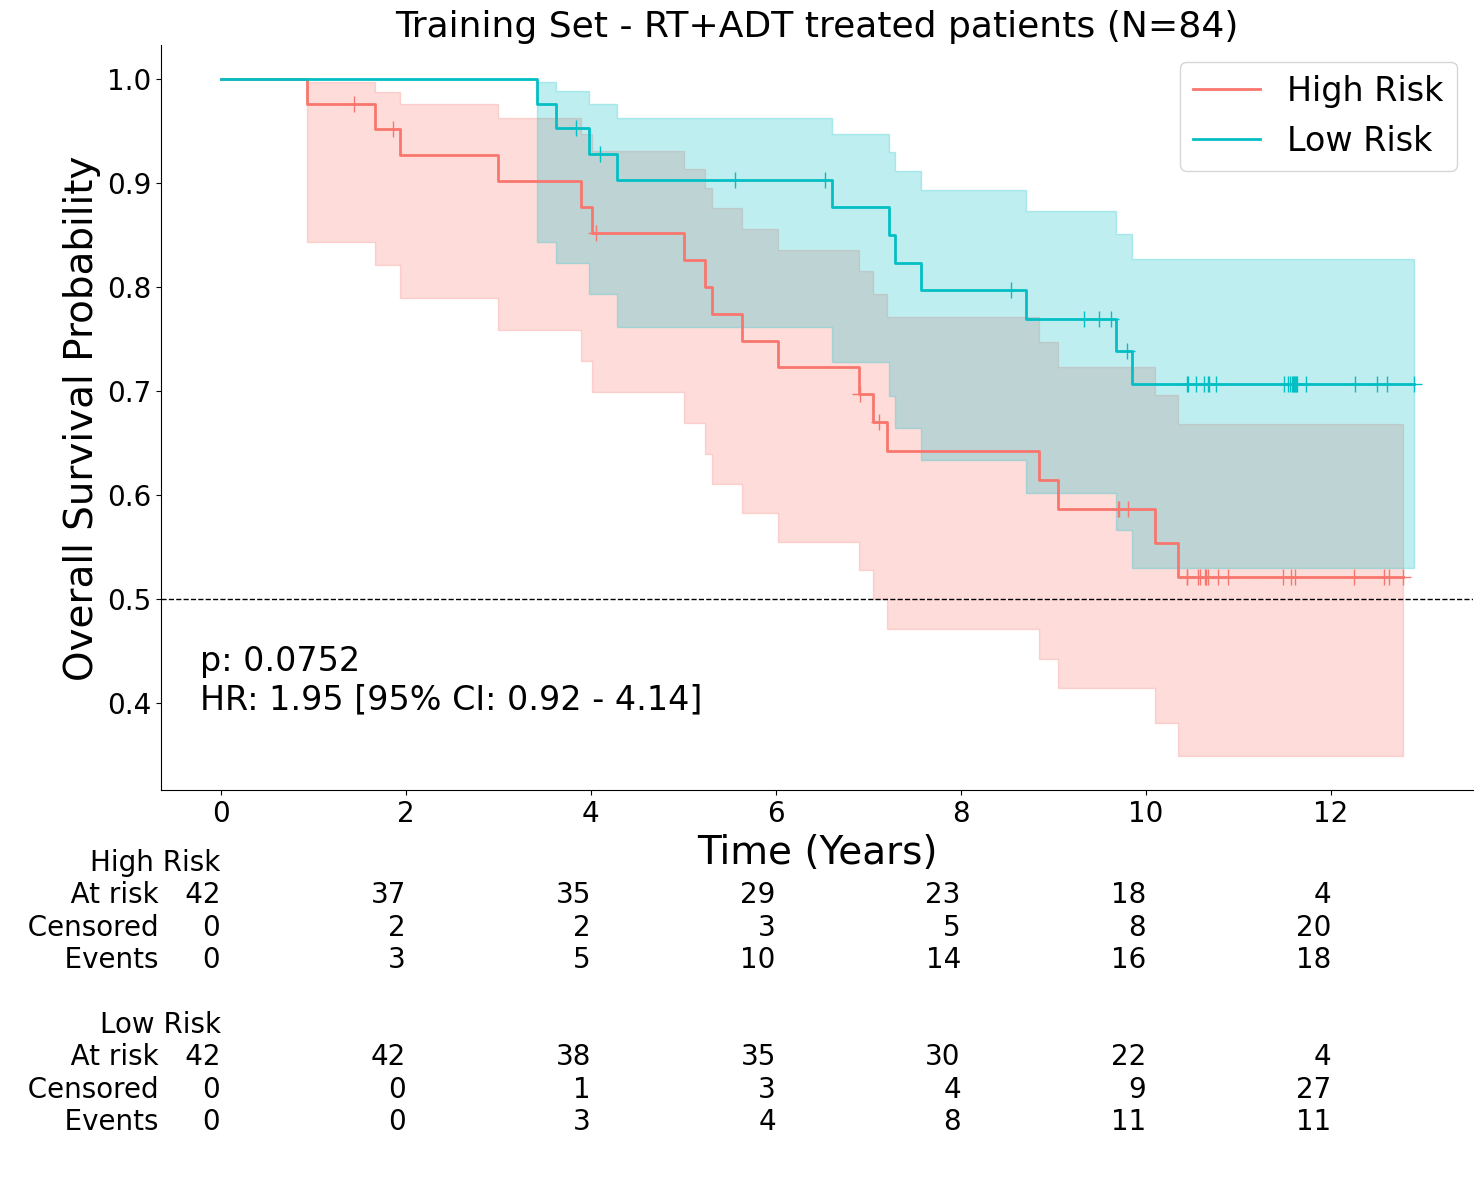

In [100]:
train_title_str = 'Training Set - RT+ADT treated patients (N={:d})'.format(len(y_training))
train_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_training_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_training, training_data_stats, train_figure_save_path, train_title_str)

#### Holdout set KM curve

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  11.57260274


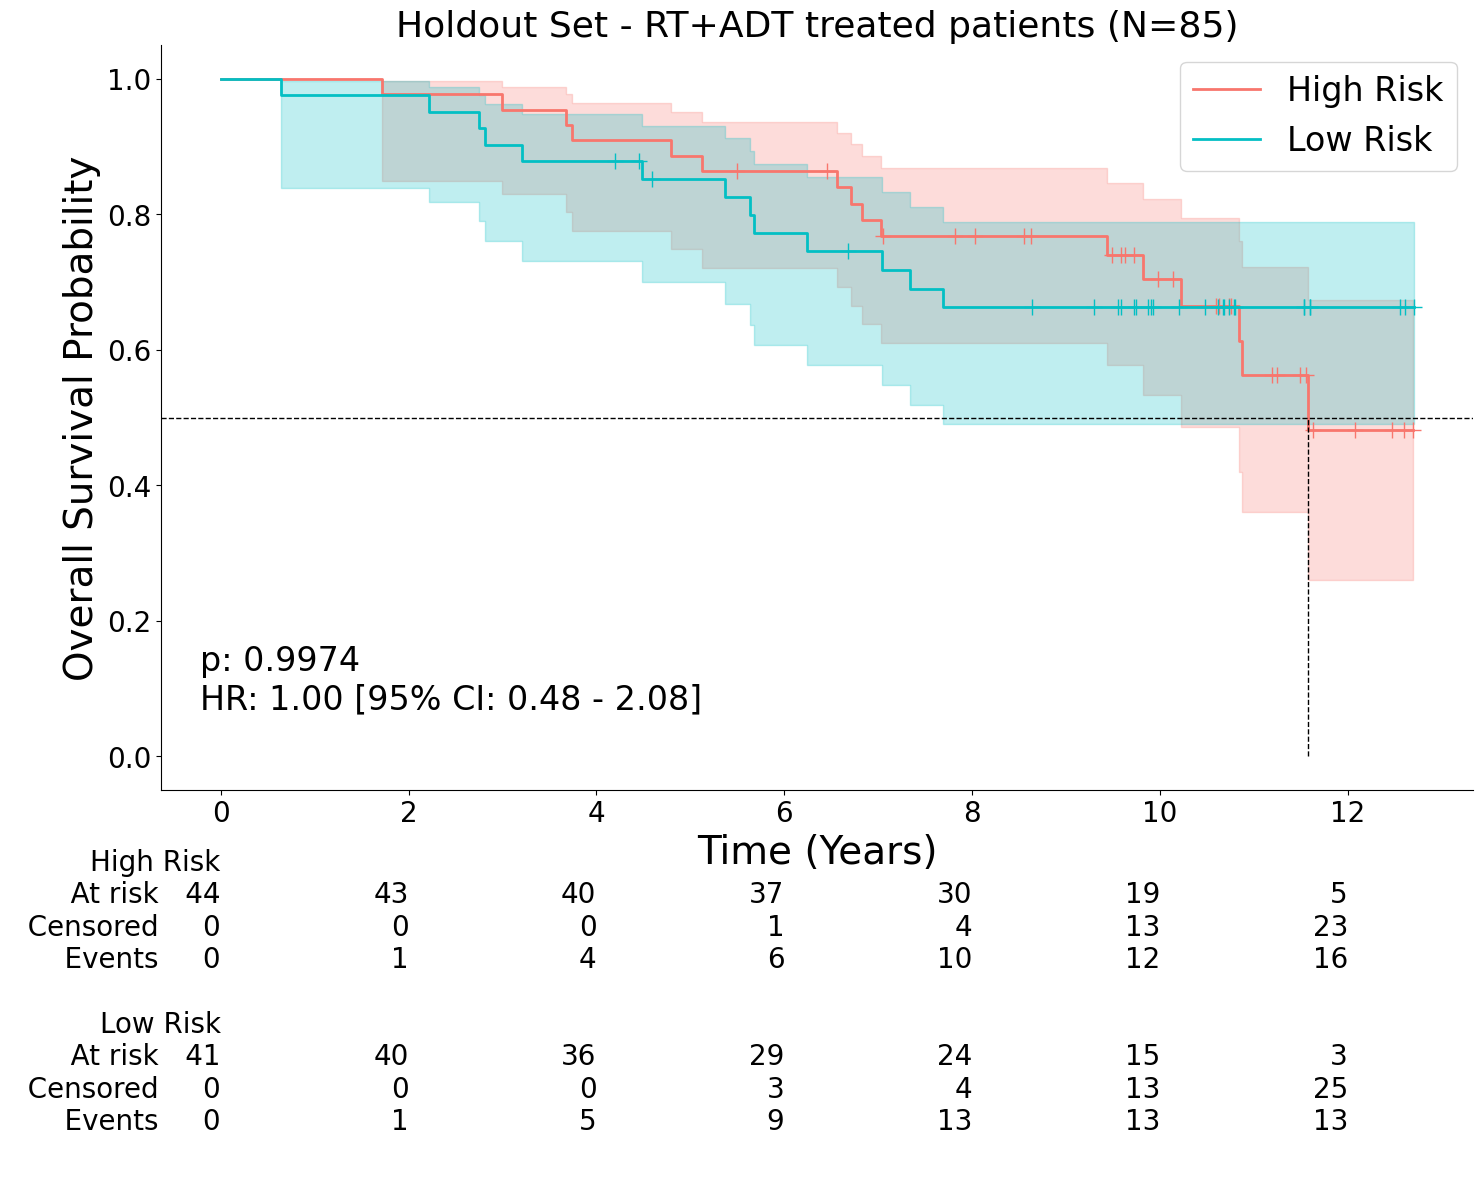

In [101]:
holdout_title_str = 'Holdout Set - RT+ADT treated patients (N={:d})'.format(len(y_holdout))
holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_holdout, holdout_data_stats, holdout_figure_save_path, holdout_title_str)

#### Test on arm 2 of the trial

In [102]:
rtog_leg_2 = rtog_features.loc[rtog_features['RX'] == 2]
X_holdout_chemo_arm = rtog_leg_2.drop(['patient_id', 'event', 'time'], axis=1).reset_index(drop=True)
y_holdout_chemo_arm = rtog_leg_2[['patient_id','event', 'time']].reset_index(drop=True)
X_holdout_chemo_arm = pd.DataFrame(scaler.transform(X_holdout_chemo_arm), columns=X_holdout_chemo_arm.columns)
X_holdout_chemo_arm_trimmed = X_holdout_chemo_arm[X_training_trimmed.columns]
y_holdout_chemo_arm_survlabel = Surv.from_dataframe('event', 'time', y_holdout_chemo_arm)

##### Predict

In [103]:
holdout_chemo_arm_risk_scores = coxnet_pred.predict(X_holdout_chemo_arm_trimmed)

In [104]:
chemo_arm_events, chemo_arm_times = y_holdout_chemo_arm['event'].values.astype(bool), y_holdout_chemo_arm['time'].values
coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

holdout_chemo_arm_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in holdout_chemo_arm_risk_scores])
holdout_chemo_arm_survival_probs = []
holdout_chemo_arm_survival_times = []

for group_label in np.unique(holdout_chemo_arm_risk_group_labels):
    group_indices = np.where(holdout_chemo_arm_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(chemo_arm_events[group_indices], chemo_arm_times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)


In [105]:
results = logrank_test(chemo_arm_times[holdout_chemo_arm_risk_group_labels==0], chemo_arm_times[holdout_chemo_arm_risk_group_labels==1], chemo_arm_events[holdout_chemo_arm_risk_group_labels==0], chemo_arm_events[holdout_chemo_arm_risk_group_labels==1])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.99      0.02

In [106]:
chemo_arm_results = multivariate_logrank_test(chemo_arm_times, holdout_chemo_arm_risk_group_labels, chemo_arm_events)
chemo_arm_results.p_value

0.9855307933655081

In [107]:
y_holdout_chemo_arm['risk_score'] = holdout_chemo_arm_risk_scores
y_holdout_chemo_arm['risk_group'] = holdout_chemo_arm_risk_group_labels
y_holdout_chemo_arm['patient_id'] = y_holdout_chemo_arm['patient_id']
y_holdout_chemo_arm = y_holdout_chemo_arm.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout_chemo_arm

,patient_id,event,time,risk_score,risk_group
0,0521-024492,0,9.430781,-0.018169,0
1,0521-031363,0,10.636477,0.377533,1
2,0521-034934,0,9.490411,0.197023,1
3,0521-039475,0,5.018340,0.313244,1
4,0521-044097,0,9.536986,0.222446,1
...,...,...,...,...,...
176,0521-972417,0,12.673973,0.624598,1
177,0521-979111,0,4.619178,-0.431883,0
178,0521-979162,0,12.649315,-0.449963,0
179,0521-998850,0,10.612606,-0.922441,0


In [108]:
print("Metrics for RTOG treatment leg cohort")
coxnet_pred = gcv.best_estimator_
chemo_arm_holdout_prediction = coxnet_pred.predict(X_holdout_chemo_arm_trimmed)
chemo_arm_holdout_survival = coxnet_pred.predict_survival_function(X_holdout_chemo_arm_trimmed)
times_holdout_chemo_arm = np.arange(int(np.min(y_holdout_chemo_arm_survlabel['time'])), int(np.max(y_holdout_chemo_arm_survlabel["time"])))
survival_prediction_holdout_chemo_arm = np.asarray([[fn(t) for t in times_holdout_chemo_arm] for fn in chemo_arm_holdout_survival])
c_index_holdout = concordance_index_censored(y_holdout_chemo_arm_survlabel["event"], y_holdout_chemo_arm_survlabel["time"], chemo_arm_holdout_prediction)
print('C-index on Holdout set: {:.3f}'.format(c_index_holdout[0]))
c_ipcw_holdout = concordance_index_ipcw(y_training_survlabel, y_holdout_chemo_arm_survlabel, chemo_arm_holdout_prediction)
print('IPCW C-index on Holdout set: {:.3f}'.format(c_ipcw_holdout[0]))
model_metrics_chemo_arm = pd.DataFrame()
model_metrics_chemo_arm['cohort'] = ["chemo_arm"]
model_metrics_chemo_arm['c_index_holdout'] = [c_index_holdout[0]]
model_metrics_chemo_arm['c_index_ipcw_holdout'] = [c_ipcw_holdout[0]]
model_metrics_chemo_arm['integrated_brier_score_holdout'] = [0]

Metrics for RTOG treatment leg cohort
C-index on Holdout set: 0.547
IPCW C-index on Holdout set: 0.553


In [109]:
LL_holdout_chemo_arm = y_holdout_chemo_arm.drop(['patient_id', 'risk_score'], axis=1)
cph_holdout_chemo_arm = CoxPHFitter()
cph_holdout_chemo_arm.fit(LL_holdout_chemo_arm, duration_col='time', event_col='event', show_progress=False)
chemo_arm_holdout_results = cph_holdout_chemo_arm.summary
chemo_arm_holdout_p = multivariate_logrank_test(y_holdout_chemo_arm['time'], y_holdout_chemo_arm['risk_group'], y_holdout_chemo_arm['event']).p_value # holdout_results['p'].values[0]
chemo_arm_holdout_hr = chemo_arm_holdout_results['exp(coef)'].values[0]
chemo_arm_holdout_ci_lower = chemo_arm_holdout_results['exp(coef) lower 95%'].values[0]
chemo_arm_holdout_ci_upper = chemo_arm_holdout_results['exp(coef) upper 95%'].values[0]
chemo_arm_holdout_log_likelihood = cph_holdout_chemo_arm.log_likelihood_
model_metrics_chemo_arm['holdout_p_value'] = [chemo_arm_holdout_p]
model_metrics_chemo_arm['holdout_hazard_ratio'] = [chemo_arm_holdout_hr]
model_metrics_chemo_arm['holdout_hr_ci_lower'] = [chemo_arm_holdout_ci_lower]
model_metrics_chemo_arm['holdout_hr_ci_upper'] = [chemo_arm_holdout_ci_upper]
model_metrics_chemo_arm['holdout_log_likelihood'] = [chemo_arm_holdout_log_likelihood]
model_metrics_chemo_arm['holdout_parameters'] = [cph_holdout_chemo_arm.params_.shape[0]]
chemo_arm_holdout_data_stats = (chemo_arm_holdout_p, chemo_arm_holdout_hr, chemo_arm_holdout_ci_lower, chemo_arm_holdout_ci_upper)

In [110]:
cph_holdout_chemo_arm.score(LL_holdout, scoring_method='log_likelihood')

-1.3804086651318104

In [111]:
cph_holdout_chemo_arm.print_summary()

<lifelines.CoxPHFitter: fitted with 181 total observations, 128 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 181
number of events observed = 53
   partial log-likelihood = -249.81
         time fit was run = 2024-05-10 21:04:28 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group  -0.01       0.99       0.28            -0.56             0.55                 0.57                 1.73

             cmp to     z    p   -log2(p)
covariate                                
risk_group     0.00 -0.02 0.99       0.02
---
Concordance = 0.48
Partial AIC = 501.62
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.02

#### Treatment arm 2 KM curve

Low risk median survival time:  inf
High risk median survival time:  inf


/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


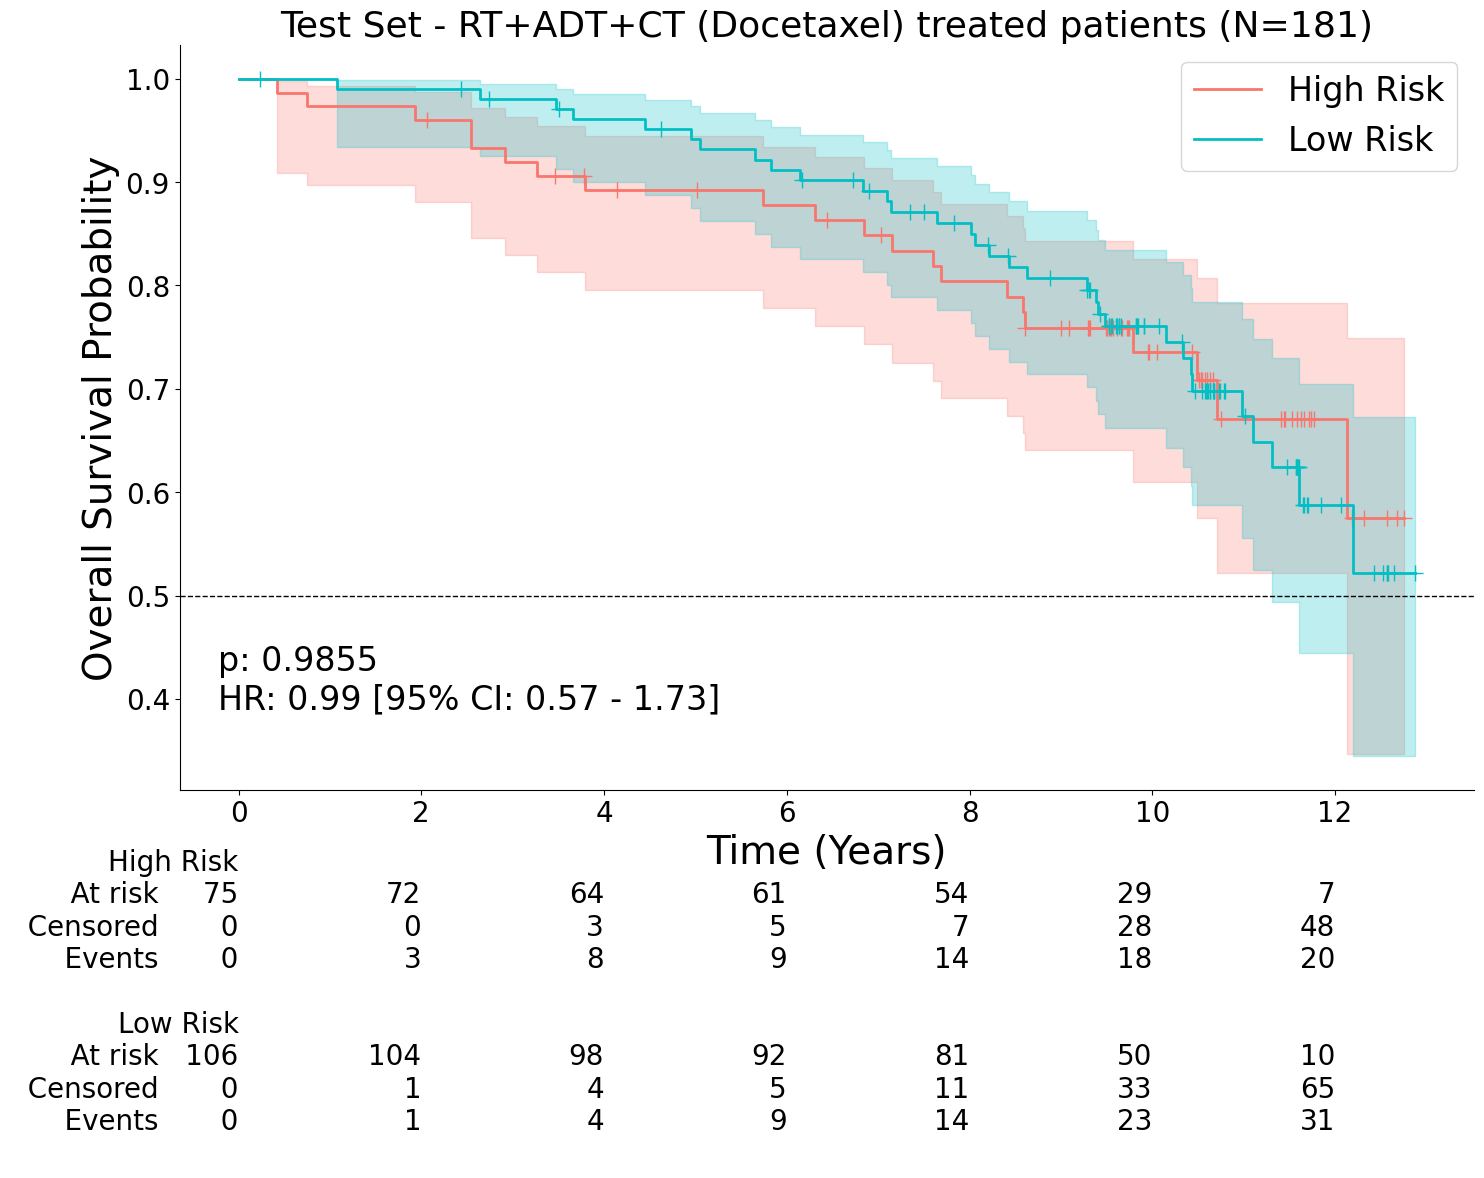

In [112]:
chemo_arm_holdout_title_str = 'Test Set - RT+ADT+CT (Docetaxel) treated patients (N={:d})'.format(len(y_holdout_chemo_arm))
chemo_arm_holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_chemo_arm_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}.png'
plot_km_curve_lifelines(y_holdout_chemo_arm, chemo_arm_holdout_data_stats, chemo_arm_holdout_figure_save_path, chemo_arm_holdout_title_str)

#### Visualization of features

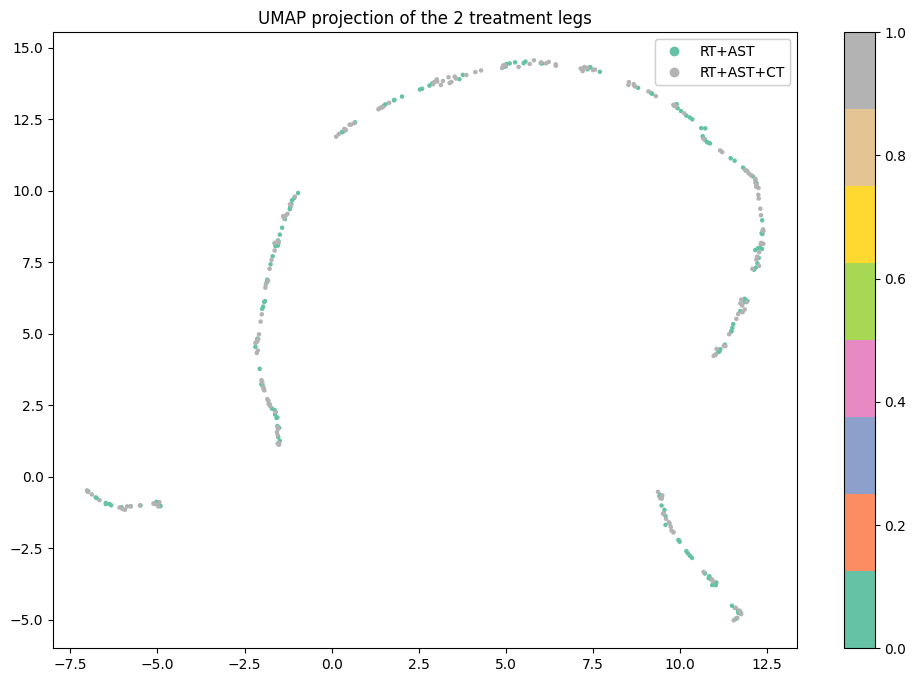

In [113]:
rt_arm_features = rtog_leg_1.drop(['patient_id','event', 'time', 'RX'], axis=1).reset_index(drop=True)
chemo_arm_features = rtog_leg_2.drop(['patient_id','event', 'time', 'RX'], axis=1).reset_index(drop=True)
rt_arm_events = rtog_leg_1['event'].values
chemo_arm_events = rtog_leg_2['event'].values
dataset1 = rt_arm_features.to_numpy()
dataset2 = chemo_arm_features.to_numpy()
combined_data = np.vstack([dataset1, dataset2])
labels = np.array([0]*len(dataset1) + [1]*len(dataset2))
reducer = umap.UMAP()
embedding = reducer.fit_transform(combined_data)
combined_labels = np.concatenate([rt_arm_events, chemo_arm_events])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Set2', s=5)
plt.colorbar()
plt.title('UMAP projection of the 2 treatment legs')
cohorts = ['RT+AST', 'RT+AST+CT']
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=cohorts)
plt.gca().add_artist(legend1)
plt.show()

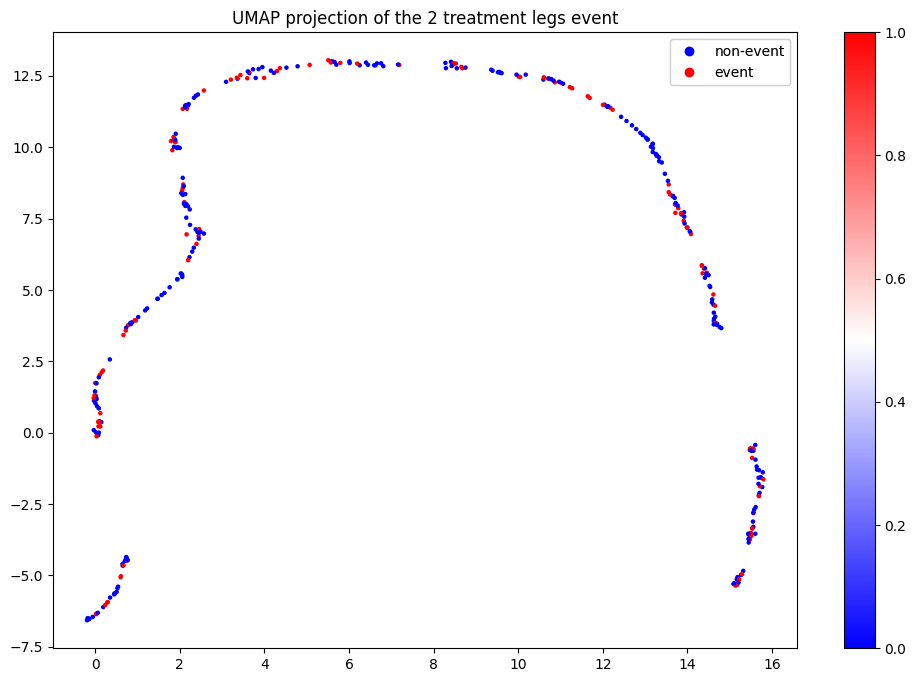

In [114]:
combined_data = np.vstack([dataset1, dataset2])
labels = np.array([0]*len(dataset1) + [1]*len(dataset2))
reducer = umap.UMAP()
embedding = reducer.fit_transform(combined_data)

# Plotting
combined_labels = np.concatenate([rt_arm_events, chemo_arm_events])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=combined_labels, cmap='bwr', s=5)
plt.colorbar()
plt.title('UMAP projection of the 2 treatment legs event')
cohorts = ['UPenn rt_arm', 'Upenn chemo_arm']
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=['non-event', 'event'])
plt.gca().add_artist(legend1)

plt.show()

#### Biomarker - patients from both treatment arms

In [115]:
chemo_favorable_risk = y_holdout_chemo_arm[y_holdout_chemo_arm['risk_group'] == 0]
chemo_favorable_risk['chemo'] = 1
no_chemo_favorable_risk = y_holdout[y_holdout['risk_group'] == 0]
no_chemo_favorable_risk['chemo'] = 0
favorable_risk = pd.concat([chemo_favorable_risk, no_chemo_favorable_risk])

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/1806258047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_favorable_risk['chemo'] = 1
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/1806258047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_favorable_risk['chemo'] = 0


In [116]:
LL_holdout_chemo_arm = favorable_risk.drop(['patient_id', 'risk_group', 'risk_score'], axis=1)
cph_holdout_chemo_arm = CoxPHFitter()
cph_holdout_chemo_arm.fit(LL_holdout_chemo_arm, duration_col='time', event_col='event', show_progress=False)

chemo_arm_holdout_results = cph_holdout_chemo_arm.summary
chemo_arm_holdout_p = multivariate_logrank_test(favorable_risk['time'], favorable_risk['chemo'], favorable_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
chemo_arm_holdout_hr = chemo_arm_holdout_results['exp(coef)'].values[0]
chemo_arm_holdout_ci_lower = chemo_arm_holdout_results['exp(coef) lower 95%'].values[0]
chemo_arm_holdout_ci_upper = chemo_arm_holdout_results['exp(coef) upper 95%'].values[0]
chemo_arm_holdout_log_likelihood = cph_holdout_chemo_arm.log_likelihood_
model_metrics_chemo_arm['holdout_p_value'] = [chemo_arm_holdout_p]
model_metrics_chemo_arm['holdout_hazard_ratio'] = [chemo_arm_holdout_hr]
model_metrics_chemo_arm['holdout_hr_ci_lower'] = [chemo_arm_holdout_ci_lower]
model_metrics_chemo_arm['holdout_hr_ci_upper'] = [chemo_arm_holdout_ci_upper]
model_metrics_chemo_arm['holdout_log_likelihood'] = [chemo_arm_holdout_log_likelihood]
model_metrics_chemo_arm['holdout_parameters'] = [cph_holdout_chemo_arm.params_.shape[0]]

chemo_arm_holdout_data_stats = (chemo_arm_holdout_p, chemo_arm_holdout_hr, chemo_arm_holdout_ci_lower, chemo_arm_holdout_ci_upper)

In [117]:
cph_holdout_chemo_arm.print_summary()

<lifelines.CoxPHFitter: fitted with 147 total observations, 102 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 45
   partial log-likelihood = -204.11
         time fit was run = 2024-05-10 21:04:30 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
chemo      -0.24       0.79       0.33            -0.88             0.41                 0.41                 1.50

            cmp to     z    p   -log2(p)
covariate                               
chemo         0.00 -0.72 0.47       1.09
---
Concordance = 0.44
Partial AIC = 410.21
log-likelihood ratio test = 0.50 on 1 df
-log2(p) of ll-ratio test = 1.06

#### KM curve of biomarker - patients

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  inf


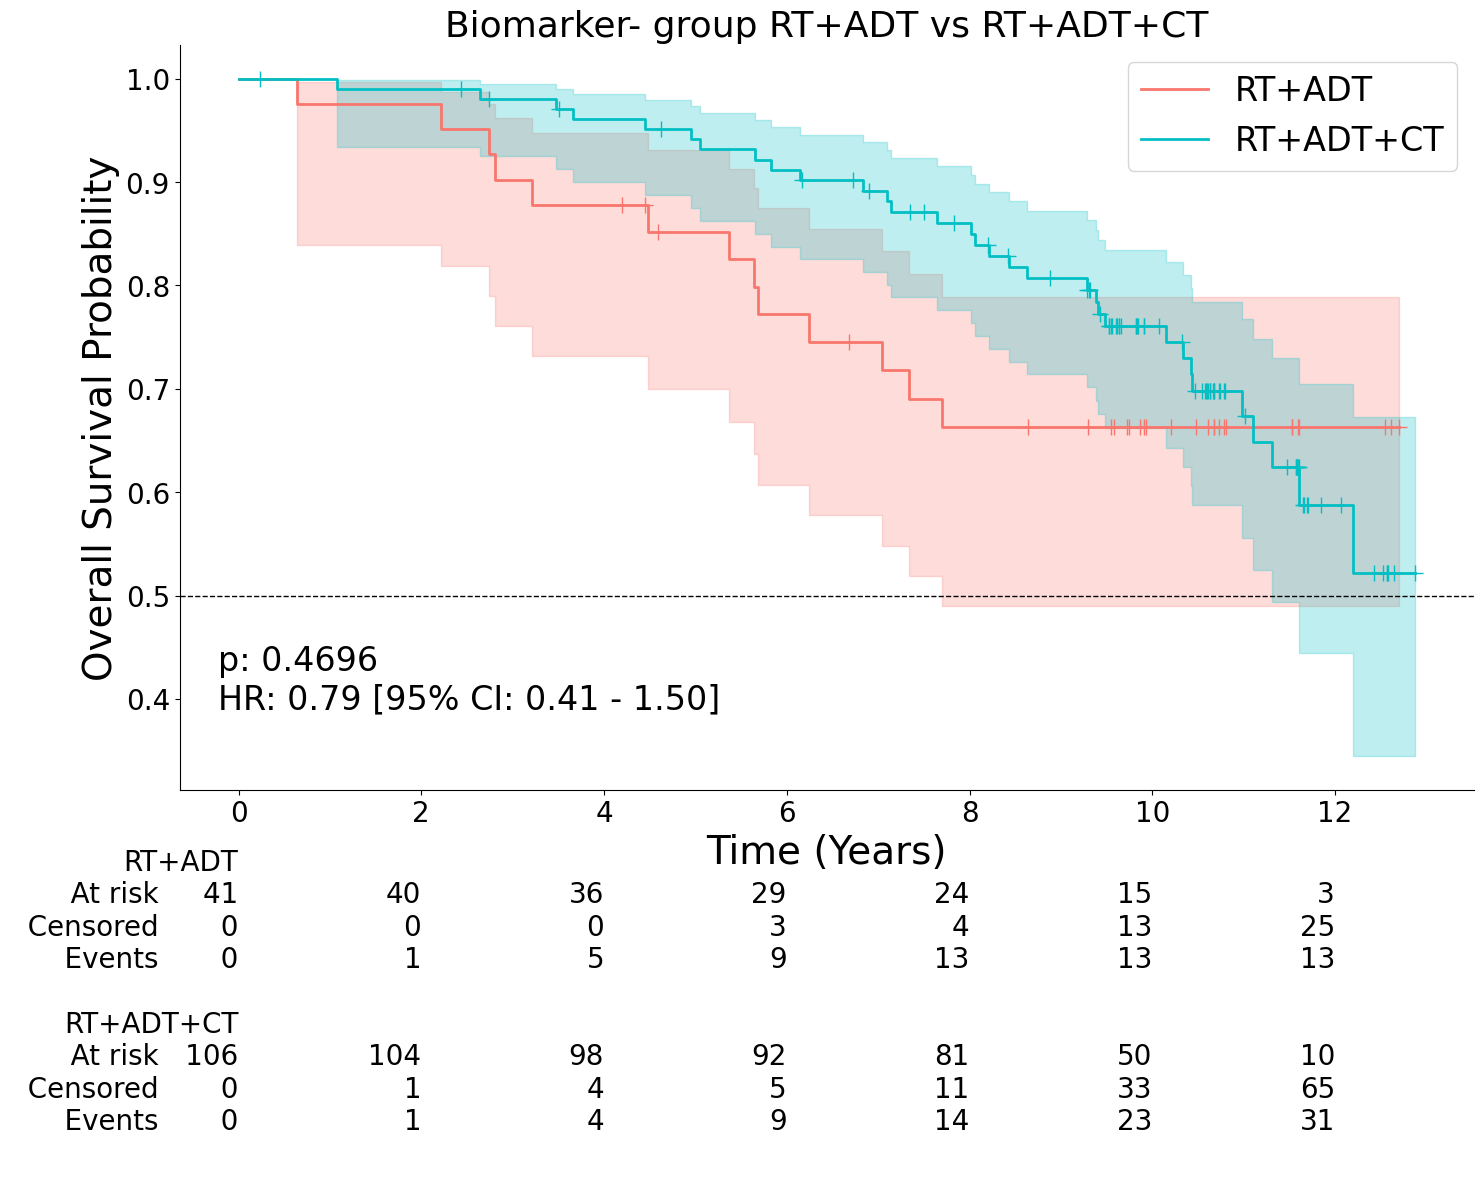

In [118]:
plot_km_same_risk_group(no_chemo_favorable_risk, chemo_favorable_risk, chemo_arm_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/favorable_risk_both_legs_km.png', "Biomarker- group RT+ADT vs RT+ADT+CT")

##### Calculating survival benefit

In [119]:
benefits = calculate_survival_benefit(no_chemo_favorable_risk, chemo_favorable_risk)
print("Survival Benefits at specified time points:", benefits)

Survival Benefits at specified time points: {1: 2.439024390243927, 3: 7.842089239200279, 5: 8.939369259804408, 7: 14.614011712893438, 10: 9.832897296119924}


#### Analyzing biomarker + patients

In [120]:
chemo_bad_risk = y_holdout_chemo_arm[y_holdout_chemo_arm['risk_group'] == 1]
no_chemo_bad_risk = y_holdout[y_holdout['risk_group'] == 1]
chemo_bad_risk['chemo'] = 1
no_chemo_bad_risk['chemo'] = 0
bad_risk = pd.concat([chemo_bad_risk, no_chemo_bad_risk])

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/1888853012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_bad_risk['chemo'] = 1
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/1888853012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_bad_risk['chemo'] = 0


In [121]:
LL_holdout_chemo_arm = bad_risk.drop(['patient_id', 'risk_group', 'risk_score'], axis=1)
cph_holdout_chemo_arm = CoxPHFitter()
cph_holdout_chemo_arm.fit(LL_holdout_chemo_arm, duration_col='time', event_col='event', show_progress=False)

chemo_arm_holdout_results = cph_holdout_chemo_arm.summary
chemo_arm_holdout_p = multivariate_logrank_test(bad_risk['time'], bad_risk['chemo'], bad_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
chemo_arm_holdout_hr = chemo_arm_holdout_results['exp(coef)'].values[0]
chemo_arm_holdout_ci_lower = chemo_arm_holdout_results['exp(coef) lower 95%'].values[0]
chemo_arm_holdout_ci_upper = chemo_arm_holdout_results['exp(coef) upper 95%'].values[0]
chemo_arm_holdout_log_likelihood = cph_holdout_chemo_arm.log_likelihood_
model_metrics_chemo_arm['holdout_p_value'] = [chemo_arm_holdout_p]
model_metrics_chemo_arm['holdout_hazard_ratio'] = [chemo_arm_holdout_hr]
model_metrics_chemo_arm['holdout_hr_ci_lower'] = [chemo_arm_holdout_ci_lower]
model_metrics_chemo_arm['holdout_hr_ci_upper'] = [chemo_arm_holdout_ci_upper]
model_metrics_chemo_arm['holdout_log_likelihood'] = [chemo_arm_holdout_log_likelihood]
model_metrics_chemo_arm['holdout_parameters'] = [cph_holdout_chemo_arm.params_.shape[0]]

chemo_arm_holdout_data_stats = (chemo_arm_holdout_p, chemo_arm_holdout_hr, chemo_arm_holdout_ci_lower, chemo_arm_holdout_ci_upper)

In [122]:
cph_holdout_chemo_arm.print_summary()

<lifelines.CoxPHFitter: fitted with 119 total observations, 82 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 119
number of events observed = 37
   partial log-likelihood = -159.61
         time fit was run = 2024-05-10 21:04:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
chemo      -0.23       0.80       0.33            -0.88             0.42                 0.42                 1.53

            cmp to     z    p   -log2(p)
covariate                               
chemo         0.00 -0.68 0.50       1.01
---
Concordance = 0.54
Partial AIC = 321.22
log-likelihood ratio test = 0.46 on 1 df
-log2(p) of ll-ratio test = 1.00

#### KM curve of biomarker + patients

Low risk median survival time:  inf
High risk median survival time:  11.57260274


/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_45519/2559867318.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


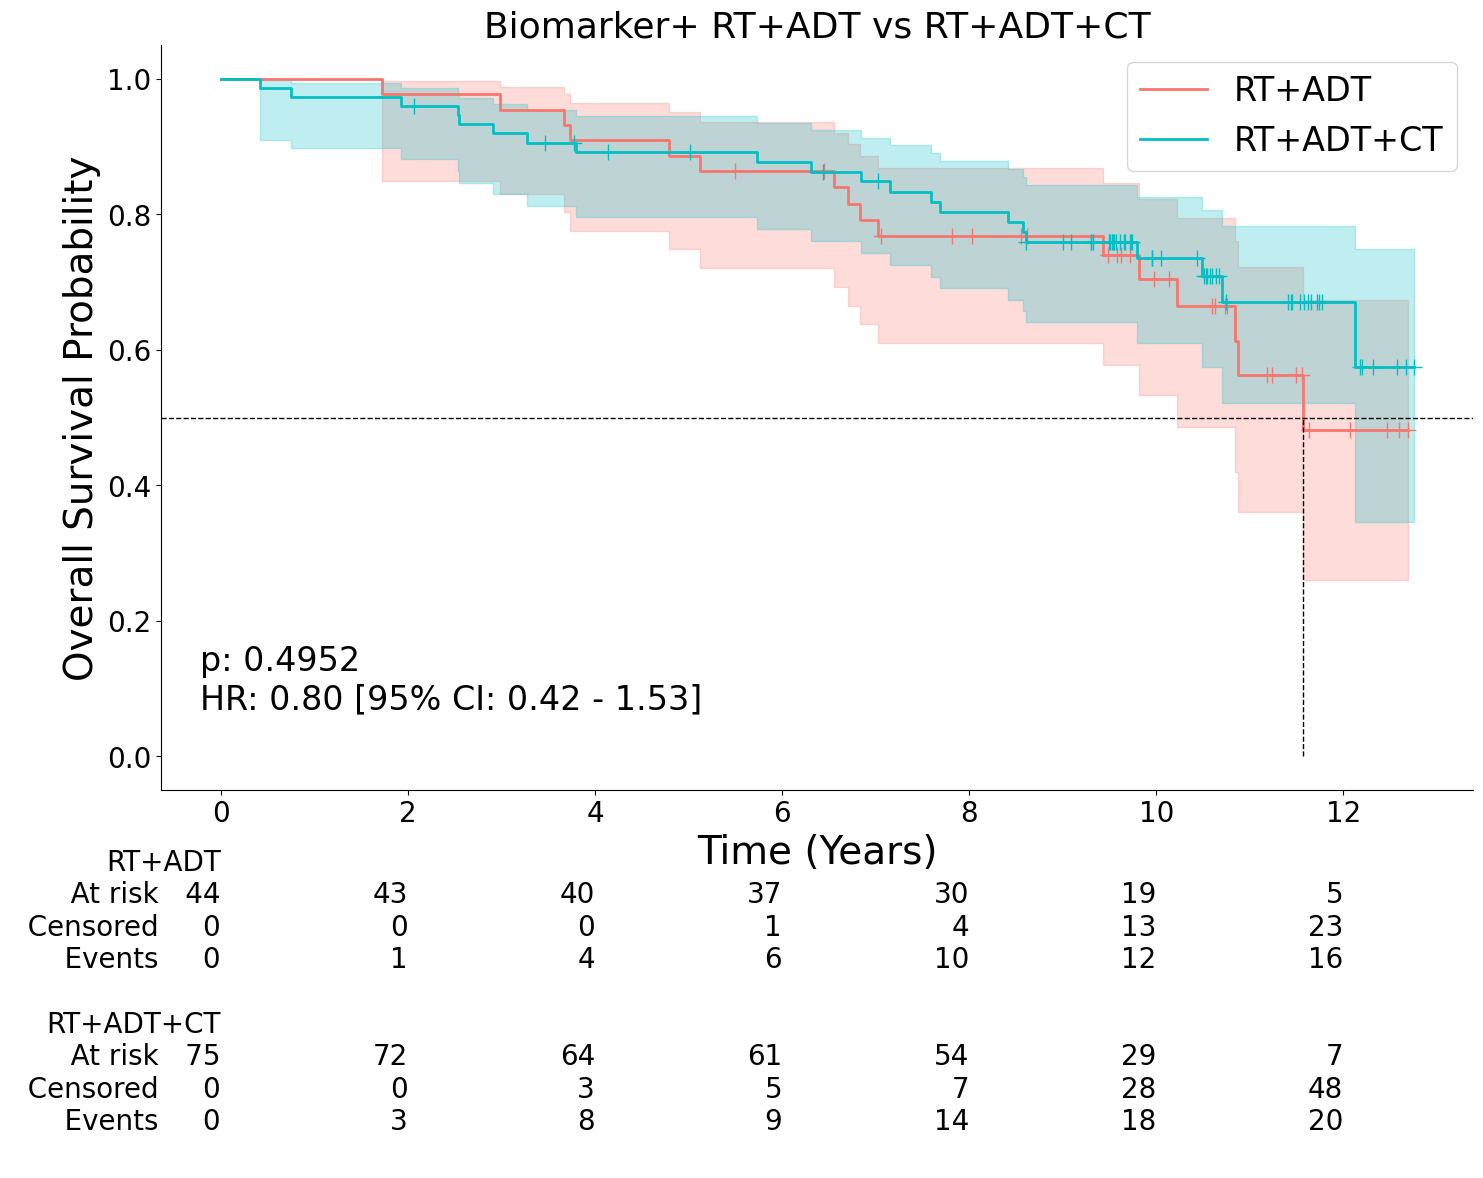

In [123]:
plot_km_same_risk_group(no_chemo_bad_risk, chemo_bad_risk, chemo_arm_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/bad_risk_both_legs_km.png', "Biomarker+ RT+ADT vs RT+ADT+CT")

#### Survival benefit

In [124]:
benefits = calculate_survival_benefit(no_chemo_bad_risk, chemo_bad_risk)
print("Survival Benefits at specified time points:", benefits)

Survival Benefits at specified time points: {1: -2.6666666666666505, 3: -3.510883482714444, 5: 0.5614695163990824, 7: 5.690757983856565, 10: 3.1481873535966876}


#### Interaction term analysis

In [125]:
interaction_term_test_df = pd.concat([no_chemo_bad_risk, chemo_bad_risk, no_chemo_favorable_risk, chemo_favorable_risk])
interaction_term_test_df['interaction_term'] = interaction_term_test_df['chemo'] * interaction_term_test_df['risk_group']
interaction_term_cox = CoxPHFitter()
interaction_term_cox.fit(interaction_term_test_df.drop(['patient_id', 'risk_score'], axis=1), duration_col='time', event_col='event', show_progress=False)
interaction_term_cox_results = interaction_term_cox.summary

In [126]:
interaction_term_cox_results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
risk_group,0.006037,1.006055,0.373578,-0.726163,0.738237,0.483762,2.092243,0.0,0.016160,0.987107,0.018721
chemo,-0.230504,0.794134,0.329204,-0.875732,0.414724,0.416557,1.513953,0.0,-0.700185,0.483812,1.047482
interaction_term,-0.006886,0.993138,0.467480,-0.923129,0.909358,0.397274,2.482727,0.0,-0.014729,0.988248,0.017055


#### Multivariable analysis

In [127]:
features

,patient_id,spatil_341,spatil_0,spatil_198,spatil_115,spatil_117,spatil_1,spatil_196,spatil_137,spatil_86,...,nucdiv_360,nucdiv_18,nucdiv_1246,nucdiv_1720,nucdiv_2131,nucdiv_293,nucdiv_2046,event,time,RX
0,0521-237186,0.000949,2.313596,0.040449,0.076989,0.077100,616639.8217,0.001183,-0.458767,0.049075,...,21.351095,0.150225,2.173635,10.058394,0.271796,0.544727,0.078474,0,12.569863,2
1,0521-972417,0.000230,0.589928,0.014388,0.122302,0.079137,505414.6437,0.000000,-0.736258,0.037996,...,28.050408,0.077229,2.222222,4.700487,0.222222,0.564670,0.084913,0,12.673973,2
2,0521-641497,0.000487,2.381323,0.040962,0.065492,0.053160,627747.8018,0.022110,NaN,0.063769,...,15.270753,0.092709,2.000000,35.447978,0.200302,0.564203,0.107131,0,12.783562,1
3,0521-650593,0.000363,0.906250,0.000000,0.187500,0.015625,387458.5295,0.000000,-0.585565,0.041645,...,3.859179,0.025633,2.000000,3.044537,0.160000,0.634821,0.100000,1,5.682192,1
4,0521-931689,0.001446,3.090164,0.081967,0.024590,0.077869,761431.0205,0.000000,0.117851,0.041437,...,37.041024,0.077692,2.000000,14.729458,0.222222,0.500000,0.090909,0,12.468493,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0521-785941,0.000732,3.281046,0.065359,0.000000,0.133987,828746.7572,0.006536,0.072355,0.111350,...,13.084241,0.165747,2.000000,11.063565,0.247327,0.527987,0.082873,0,9.619178,1
346,0521-227777,0.001024,3.107306,0.052511,0.027397,0.092466,742567.9167,0.006849,-0.219583,0.078424,...,41.229004,0.109228,2.000000,12.902779,0.198347,0.611852,0.100000,0,9.731507,2
347,0521-225186,0.001610,3.624242,0.042424,0.018182,0.084848,694474.1551,0.006061,-0.192190,0.103269,...,7.114129,0.068559,1.944444,6.984021,0.222222,0.607143,0.093169,1,4.794521,1
348,0521-601511,0.000279,1.300000,0.093750,0.025000,0.275000,848550.0244,0.000000,-0.707107,0.000000,...,34.355417,0.090418,1.923077,20.819353,0.222222,0.644298,0.095238,1,7.690411,2


In [128]:
corr_matrix_df = features.drop(columns=['RX', 'patient_id', 'event', 'time', 'nucdiv_risk_group', 'risk_group'])

KeyError: "['nucdiv_risk_group', 'risk_group'] not found in axis"

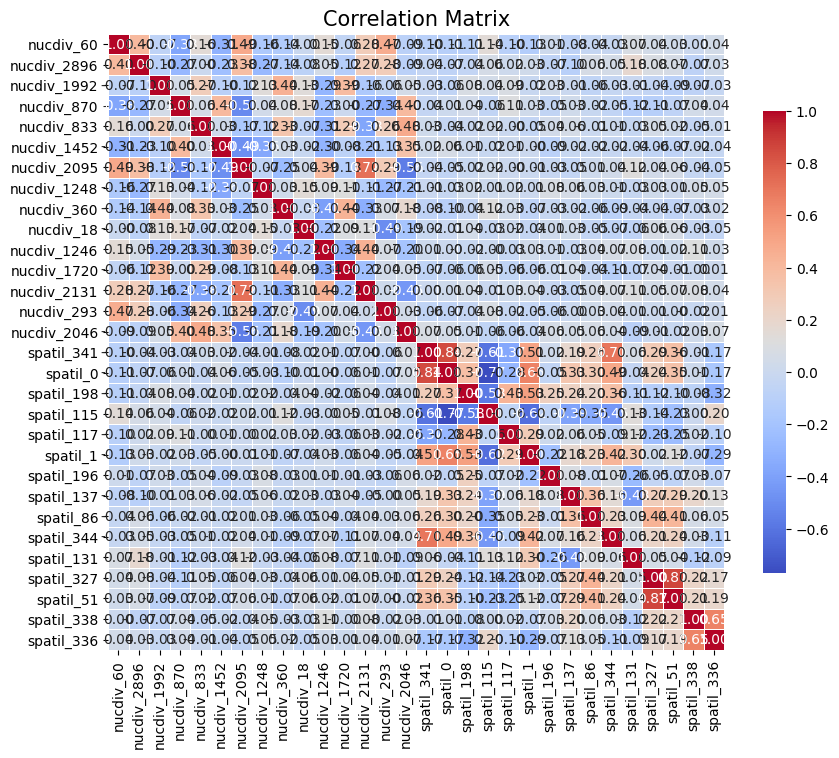

In [ ]:
corr_matrix = corr_matrix_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix', size=15)
plt.show()

## The naive way

In [11]:
rtog_leg_1

,spatil_341,spatil_0,spatil_198,spatil_115,spatil_117,spatil_1,spatil_196,spatil_137,spatil_86,spatil_344,...,nucdiv_18,nucdiv_1246,nucdiv_1720,nucdiv_2131,nucdiv_293,nucdiv_2046,patient_id,RX,time,event
2,0.000487,2.381323,0.040962,0.065492,0.053160,627747.8018,0.022110,-0.369564,0.063769,0.000051,...,0.092709,2.000000,35.447978,0.200302,0.564203,0.107131,0521-641497,1,12.783562,0
3,0.000363,0.906250,0.000000,0.187500,0.015625,387458.5295,0.000000,-0.585565,0.041645,0.000091,...,0.025633,2.000000,3.044537,0.160000,0.634821,0.100000,0521-650593,1,5.682192,1
4,0.001446,3.090164,0.081967,0.024590,0.077869,761431.0205,0.000000,0.117851,0.041437,0.000355,...,0.077692,2.000000,14.729458,0.222222,0.500000,0.090909,0521-931689,1,12.468493,0
7,0.000153,0.720529,0.031974,0.089026,0.166357,701229.0446,0.004356,-0.294069,0.076614,0.000042,...,0.099909,1.906398,19.894289,0.188823,0.502761,0.099727,0521-493806,1,6.895890,1
11,0.000461,1.374759,0.067954,0.030884,0.199916,793492.3094,0.009401,0.039153,0.072649,0.000103,...,0.215278,1.823308,17.076492,0.276345,0.513582,0.088203,0521-948904,1,4.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.000482,1.840550,0.027651,0.082764,0.083610,508513.1122,0.001567,-0.569966,0.074602,0.000079,...,0.067235,2.000000,19.244418,0.182041,0.619048,0.086478,0521-066912,1,8.621918,0
344,0.001232,2.967074,0.071705,0.018746,0.121238,825493.7378,0.005102,-0.369564,0.031540,0.000224,...,0.092926,2.011705,18.658686,0.456077,0.616467,0.073176,0521-854996,1,8.641096,0
345,0.000732,3.281046,0.065359,0.000000,0.133987,828746.7572,0.006536,0.072355,0.111350,0.000092,...,0.165747,2.000000,11.063565,0.247327,0.527987,0.082873,0521-785941,1,9.619178,0
347,0.001610,3.624242,0.042424,0.018182,0.084848,694474.1551,0.006061,-0.192190,0.103269,0.000145,...,0.068559,1.944444,6.984021,0.222222,0.607143,0.093169,0521-225186,1,4.794521,1


In [12]:
# select some specific columns from the df
selected_cols = ['patient_id', 'RX', 'time', 'event', 'nucdiv_60', 'spatil_0', 'spatil_341', 'nucdiv_293', 'spatil_51', 'spatil_336', 'spatil_338'] # nucdiv_360, nucdiv_2095

# create a new df with the selected columns
selected_df = rtog_leg_1[selected_cols]
training_data, holdout_data = train_test_split(selected_df, test_size=split_percentage, random_state=seed, stratify=selected_df['event'])


In [13]:
training_data

,patient_id,RX,time,event,nucdiv_60,spatil_0,spatil_341,nucdiv_293,spatil_51,spatil_336,spatil_338
266,0521-421010,1,2.989019,1,0.310855,1.461538,0.000384,0.582583,0.001716,0.000000,0.000000
109,0521-498482,1,7.219178,1,0.456132,2.572383,0.000821,0.639456,0.008401,0.000036,0.000000
169,0521-762304,1,10.731724,0,0.347192,2.875817,0.001197,0.628571,0.028677,0.000066,0.000040
321,0521-061895,1,4.449315,0,0.375172,2.457190,0.000960,0.629288,0.008499,0.000046,0.000000
54,0521-042494,1,12.550685,0,0.547170,0.574582,0.000025,0.676398,0.000101,0.000210,0.000027
...,...,...,...,...,...,...,...,...,...,...,...
79,0521-338806,1,11.572603,1,0.217760,0.347793,0.000077,0.500000,0.006551,0.000095,0.000005
84,0521-838930,1,11.630137,0,0.308987,3.836207,0.001960,0.562500,0.029904,0.000045,0.000045
209,0521-837382,1,7.053529,0,0.306401,1.361096,0.000381,0.584821,0.022955,0.000075,0.000000
148,0521-625587,1,3.208219,1,0.367184,0.605263,0.000571,0.622024,0.003064,0.000000,0.000000


In [14]:
scaler = MinMaxScaler()
X_train = training_data.drop(columns=['patient_id', 'event', 'time', 'RX'], axis=1)
X_val = holdout_data.drop(columns=['patient_id', 'event', 'time', 'RX'], axis=1)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_train['patient_id'] = training_data['patient_id'].values
X_train['time'] = training_data['time'].values
X_train['event'] = training_data['event'].values
X_val['patient_id'] = holdout_data['patient_id'].values
X_val['time'] = holdout_data['time'].values
X_val['event'] = holdout_data['event'].values

In [15]:
X_train

,nucdiv_60,spatil_0,spatil_341,nucdiv_293,spatil_51,spatil_336,spatil_338,patient_id,time,event
0,0.314007,0.244894,0.153347,0.455915,0.031399,0.000000,0.000000,0521-421010,2.989019,1
1,0.605428,0.475876,0.328270,0.690867,0.153700,0.102763,0.000000,0521-498482,7.219178,1
2,0.386898,0.538969,0.478360,0.645902,0.524650,0.187492,0.181566,0521-762304,10.731724,0
3,0.443025,0.451923,0.383727,0.648861,0.155492,0.133105,0.000000,0521-061895,4.449315,0
4,0.788048,0.060467,0.009991,0.843482,0.001845,0.602422,0.122878,0521-042494,12.550685,0
...,...,...,...,...,...,...,...,...,...,...
79,0.127261,0.013310,0.030771,0.114754,0.119859,0.272221,0.023934,0521-338806,11.572603,1
80,0.310259,0.738666,0.783089,0.372951,0.547089,0.127953,0.204949,0521-838930,11.630137,0
81,0.305072,0.224009,0.152375,0.465164,0.419971,0.214113,0.000000,0521-837382,7.053529,0
82,0.427000,0.066846,0.228277,0.618852,0.056059,0.000000,0.000000,0521-625587,3.208219,1


In [16]:
y_training_survlabel = Surv.from_dataframe('event', 'time', training_data)
y_holdout_survlabel = Surv.from_dataframe('event', 'time', holdout_data)

In [17]:
X_training = X_train.drop(['patient_id', 'event', 'time'], axis=1)
X_holdout = X_val.drop(['patient_id', 'event', 'time'], axis=1)
y_training = X_train[['patient_id','event', 'time']].reset_index(drop=True)
y_holdout = X_val[['patient_id','event', 'time']].reset_index(drop=True)

In [18]:
X_training

,nucdiv_60,spatil_0,spatil_341,nucdiv_293,spatil_51,spatil_336,spatil_338
0,0.314007,0.244894,0.153347,0.455915,0.031399,0.000000,0.000000
1,0.605428,0.475876,0.328270,0.690867,0.153700,0.102763,0.000000
2,0.386898,0.538969,0.478360,0.645902,0.524650,0.187492,0.181566
3,0.443025,0.451923,0.383727,0.648861,0.155492,0.133105,0.000000
4,0.788048,0.060467,0.009991,0.843482,0.001845,0.602422,0.122878
...,...,...,...,...,...,...,...
79,0.127261,0.013310,0.030771,0.114754,0.119859,0.272221,0.023934
80,0.310259,0.738666,0.783089,0.372951,0.547089,0.127953,0.204949
81,0.305072,0.224009,0.152375,0.465164,0.419971,0.214113,0.000000
82,0.427000,0.066846,0.228277,0.618852,0.056059,0.000000,0.000000


In [19]:
X_holdout

,nucdiv_60,spatil_0,spatil_341,nucdiv_293,spatil_51,spatil_336,spatil_338
0,0.309559,0.619645,0.621899,0.557377,8.999317e-02,0.095320,0.000000
1,0.046391,0.003372,0.000000,0.114754,3.128464e-11,0.446163,0.000000
2,1.014211,-0.009140,0.123516,0.839435,1.154632e-01,0.560092,0.000000
3,0.355799,0.658361,0.399749,0.645902,8.319110e-02,0.000000,0.000000
4,0.352420,0.494920,0.378229,0.551544,5.623177e-01,0.224132,0.000000
...,...,...,...,...,...,...,...
80,0.042262,0.017438,0.000000,0.259344,0.000000e+00,0.616431,0.000000
81,0.324413,0.092956,0.074621,0.571763,1.558587e-01,0.331317,0.095826
82,0.353898,0.659055,0.516608,0.619194,5.238570e-01,0.181195,0.220538
83,0.319525,0.297371,0.154966,0.372951,2.770599e-01,0.089595,0.000000


In [21]:
# coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(alpha_min_ratio=0.00001, fit_baseline_model=True))
# warnings.simplefilter("ignore", UserWarning)
# warnings.simplefilter("ignore", FitFailedWarning)
# coxnet_pipe.fit(X_training, y_training_survlabel)

# estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
# param_grid = {
#     'coxnetsurvivalanalysis__l1_ratio': np.linspace(0, 1, 20),  # Explore l1_ratio between 0.1 and 0.9
#     'coxnetsurvivalanalysis__alphas': [[alpha] for alpha in estimated_alphas]  # Use estimated alphas
# }
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# gcv = GridSearchCV(
#     make_pipeline(CoxnetSurvivalAnalysis(fit_baseline_model=True)),
#     param_grid=param_grid,
#     cv=cv,
#     error_score=0.5,
#     n_jobs=1,
# ).fit(X_training, y_training_survlabel)


cph = CoxPHFitter()
cph.fit(X_train.drop(columns=['patient_id']), duration_col='time', event_col='event', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 84 total observations, 55 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 84
number of events observed = 29
   partial log-likelihood = -114.24
         time fit was run = 2024-05-20 18:19:51 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
nucdiv_60   -1.92       0.15       1.47            -4.81             0.97                 0.01                 2.64
spatil_0    -4.89       0.01       2.14            -9.09            -0.69                 0.00                 0.50
spatil_341   3.65      38.32       2.20            -0.66             7.95                 0.52              2847.23
nucdiv_293   0.80       2.22       1.27            -1.70             3.29                 0.18                26.81
spatil_51    0.52       1.68       1.16            -1.75             2.79                 0.17                16.22
spatil_336  -1.77       0.17       1.58            -4.86             1.32                 0.01                 3.73
spatil_338  -0.04       0.96       2.04            -4.03             3.96                 0.02                52.47

             cmp to     z    p   -log2(p)
covariate                                
nucdiv_60      0.00 -1.30 0.19       2.37
spatil_0       0.00 -2.28 0.02       5.48
spatil_341     0.00  1.66 0.10       3.36
nucdiv_293     0.00  0.63 0.53       0.91
spatil_51      0.00  0.45 0.65       0.61
spatil_336     0.00 -1.12 0.26       1.94
spatil_338     0.00 -0.02 0.99       0.02
---
Concordance = 0.65
Partial AIC = 242.49
log-likelihood ratio test = 10.58 on 7 df
-log2(p) of ll-ratio test = 2.66

In [22]:
training_risk_scores = cph.predict_partial_hazard(X_train)
holdout_risk_scores = cph.predict_partial_hazard(X_holdout)

In [23]:
risk_threshold = np.median(training_risk_scores)

In [24]:
risk_threshold

1.1185251638807179

In [25]:
events, times = y_training['event'].values.astype(bool),   y_training['time'].values

In [26]:
mean = np.mean(training_risk_scores)
std = np.std(training_risk_scores)
lower_bound = mean - std
upper_bound = mean + std
threshold_values = np.linspace(lower_bound, upper_bound, num=int((upper_bound - (lower_bound)) / 0.001) + 1)
p_values = []
thresholds = []

for threshold in threshold_values:
    train_risk_group_labels = np.array([1 if x > threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
    #p_values.append(multivariate_logrank_test(times, train_risk_group_labels, events).p_value)
    thresholds.append(threshold)
    p_values.append(logrank_test(times[train_risk_group_labels==0], times[train_risk_group_labels==1], events[train_risk_group_labels==0], events[train_risk_group_labels==1]).p_value)



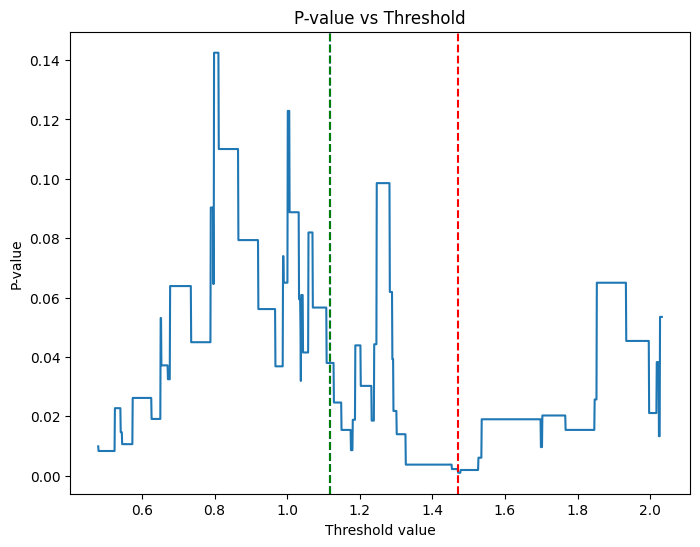

In [27]:
# plot p values vs thresholds
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, p_values)
ax.set_xlabel("Threshold value")
ax.set_ylabel("P-value")
ax.set_title("P-value vs Threshold")
#plot a red line in the minimum p-value
min_pval_idx = np.argmin(p_values)
ax.axvline(risk_threshold, color='blue', linestyle='--')
ax.axvline(thresholds[min_pval_idx], color='r', linestyle='--')
ax.axvline(np.median(training_risk_scores), color='g', linestyle='--')

In [28]:
# risk_threshold = 1.18

In [29]:
train_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
train_survival_probs = []
train_survival_times = []
events, times = y_training['event'].values.astype(bool),   y_training['time'].values

for group_label in np.unique(train_risk_group_labels):
    group_indices = np.where(train_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    train_survival_probs.append(group_survival_prob)
    train_survival_times.append(group_time)

events, times = y_holdout['event'].values.astype(bool),   y_holdout['time'].values
holdout_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in holdout_risk_scores])#np.digitize(test_risk_scores, risk_groups)
holdout_survival_probs = []
holdout_survival_times = []

for group_label in np.unique(holdout_risk_group_labels):
    group_indices = np.where(holdout_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)

In [30]:
y_holdout['risk_score'] = holdout_risk_scores
y_holdout['risk_group'] = holdout_risk_group_labels
y_holdout['patient_id'] = y_holdout['patient_id']
y_holdout = y_holdout.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout

,patient_id,event,time,risk_score,risk_group
0,0521-002001,0,7.111790,1.252076,1
1,0521-029609,0,11.534247,3.590412,1
2,0521-035384,0,9.703099,2.192620,1
3,0521-046445,0,6.528767,2.203340,1
4,0521-061104,0,11.600000,0.795869,0
...,...,...,...,...,...
80,0521-917820,1,5.121514,1.626627,1
81,0521-919234,1,6.706849,3.077538,1
82,0521-923895,0,10.453567,0.754107,0
83,0521-934543,1,3.413699,3.141846,1


In [31]:
y_training['risk_score'] = training_risk_scores
y_training['risk_group'] = train_risk_group_labels
y_training['patient_id'] = y_training['patient_id']
y_training = y_training.sort_values(by=['patient_id']).reset_index(drop=True)
y_training

,patient_id,event,time,risk_score,risk_group
0,0521-011235,0,10.736986,0.795672,0
1,0521-031663,0,9.978082,1.470048,1
2,0521-032790,1,2.810959,1.246490,1
3,0521-039456,1,1.936986,0.797594,0
4,0521-042494,0,12.550685,0.414998,0
...,...,...,...,...,...
79,0521-966640,1,3.983562,1.852251,1
80,0521-968370,0,12.610959,1.031888,0
81,0521-983798,0,10.441680,0.198011,0
82,0521-989175,0,10.780844,1.043017,0


In [32]:
y_training

,patient_id,event,time,risk_score,risk_group
0,0521-011235,0,10.736986,0.795672,0
1,0521-031663,0,9.978082,1.470048,1
2,0521-032790,1,2.810959,1.246490,1
3,0521-039456,1,1.936986,0.797594,0
4,0521-042494,0,12.550685,0.414998,0
...,...,...,...,...,...
79,0521-966640,1,3.983562,1.852251,1
80,0521-968370,0,12.610959,1.031888,0
81,0521-983798,0,10.441680,0.198011,0
82,0521-989175,0,10.780844,1.043017,0


In [33]:
LL_train = y_training.drop(['patient_id', 'risk_score'], axis=1)
LL_holdout = y_holdout.drop(['patient_id', 'risk_score'], axis=1)
cph_train = CoxPHFitter()
cph_train.fit(LL_train, duration_col='time', event_col='event', show_progress=False)
cph_holdout = CoxPHFitter()
cph_holdout.fit(LL_holdout, duration_col='time', event_col='event', show_progress=False)
training_results = cph_train.summary
training_p = multivariate_logrank_test(y_training['time'], y_training['risk_group'], y_training['event']).p_value# training_results['p'].values[0]
training_hr = training_results['exp(coef)'].values[0]
training_ci_lower = training_results['exp(coef) lower 95%'].values[0]
training_ci_upper = training_results['exp(coef) upper 95%'].values[0]
training_log_likelihood = cph_train.log_likelihood_
model_metrics = pd.DataFrame()
model_metrics['training_p_value'] = [training_p]
model_metrics['training_hazard_ratio'] = [training_hr]
model_metrics['training_hr_ci_lower'] = [training_ci_lower]
model_metrics['training_hr_ci_upper'] = [training_ci_upper]
model_metrics['training_log_likelihood'] = [training_log_likelihood]
model_metrics['training_parameters'] = [cph_train.params_.shape[0]]
training_data_stats = (training_p, training_hr, training_ci_lower, training_ci_upper)
holdout_results = cph_holdout.summary
holdout_p = multivariate_logrank_test(y_holdout['time'], y_holdout['risk_group'], y_holdout['event']).p_value # holdout_results['p'].values[0]
holdout_hr = holdout_results['exp(coef)'].values[0]
holdout_ci_lower = holdout_results['exp(coef) lower 95%'].values[0]
holdout_ci_upper = holdout_results['exp(coef) upper 95%'].values[0]
holdout_log_likelihood = cph_holdout.log_likelihood_
model_metrics['holdout_p_value'] = [holdout_p]
model_metrics['holdout_hazard_ratio'] = [holdout_hr]
model_metrics['holdout_hr_ci_lower'] = [holdout_ci_lower]
model_metrics['holdout_hr_ci_upper'] = [holdout_ci_upper]
model_metrics['holdout_log_likelihood'] = [holdout_log_likelihood]
model_metrics['holdout_parameters'] = [cph_holdout.params_.shape[0]]
holdout_data_stats = (holdout_p, holdout_hr, holdout_ci_lower, holdout_ci_upper)

In [34]:
cph_train.print_summary()

<lifelines.CoxPHFitter: fitted with 84 total observations, 55 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 84
number of events observed = 29
   partial log-likelihood = -117.37
         time fit was run = 2024-05-20 18:20:09 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.79       2.21       0.39             0.02             1.56                 1.02                 4.75

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 2.02 0.04       4.53
---
Concordance = 0.60
Partial AIC = 236.74
log-likelihood ratio test = 4.33 on 1 df
-log2(p) of ll-ratio test = 4.74

In [35]:
cph_holdout.print_summary()

<lifelines.CoxPHFitter: fitted with 85 total observations, 56 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 29
   partial log-likelihood = -115.50
         time fit was run = 2024-05-20 18:20:09 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.79       2.21       0.38             0.05             1.54                 1.05                 4.65

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 2.09 0.04       4.79
---
Concordance = 0.61
Partial AIC = 233.00
log-likelihood ratio test = 4.47 on 1 df
-log2(p) of ll-ratio test = 4.86

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  11.57260274


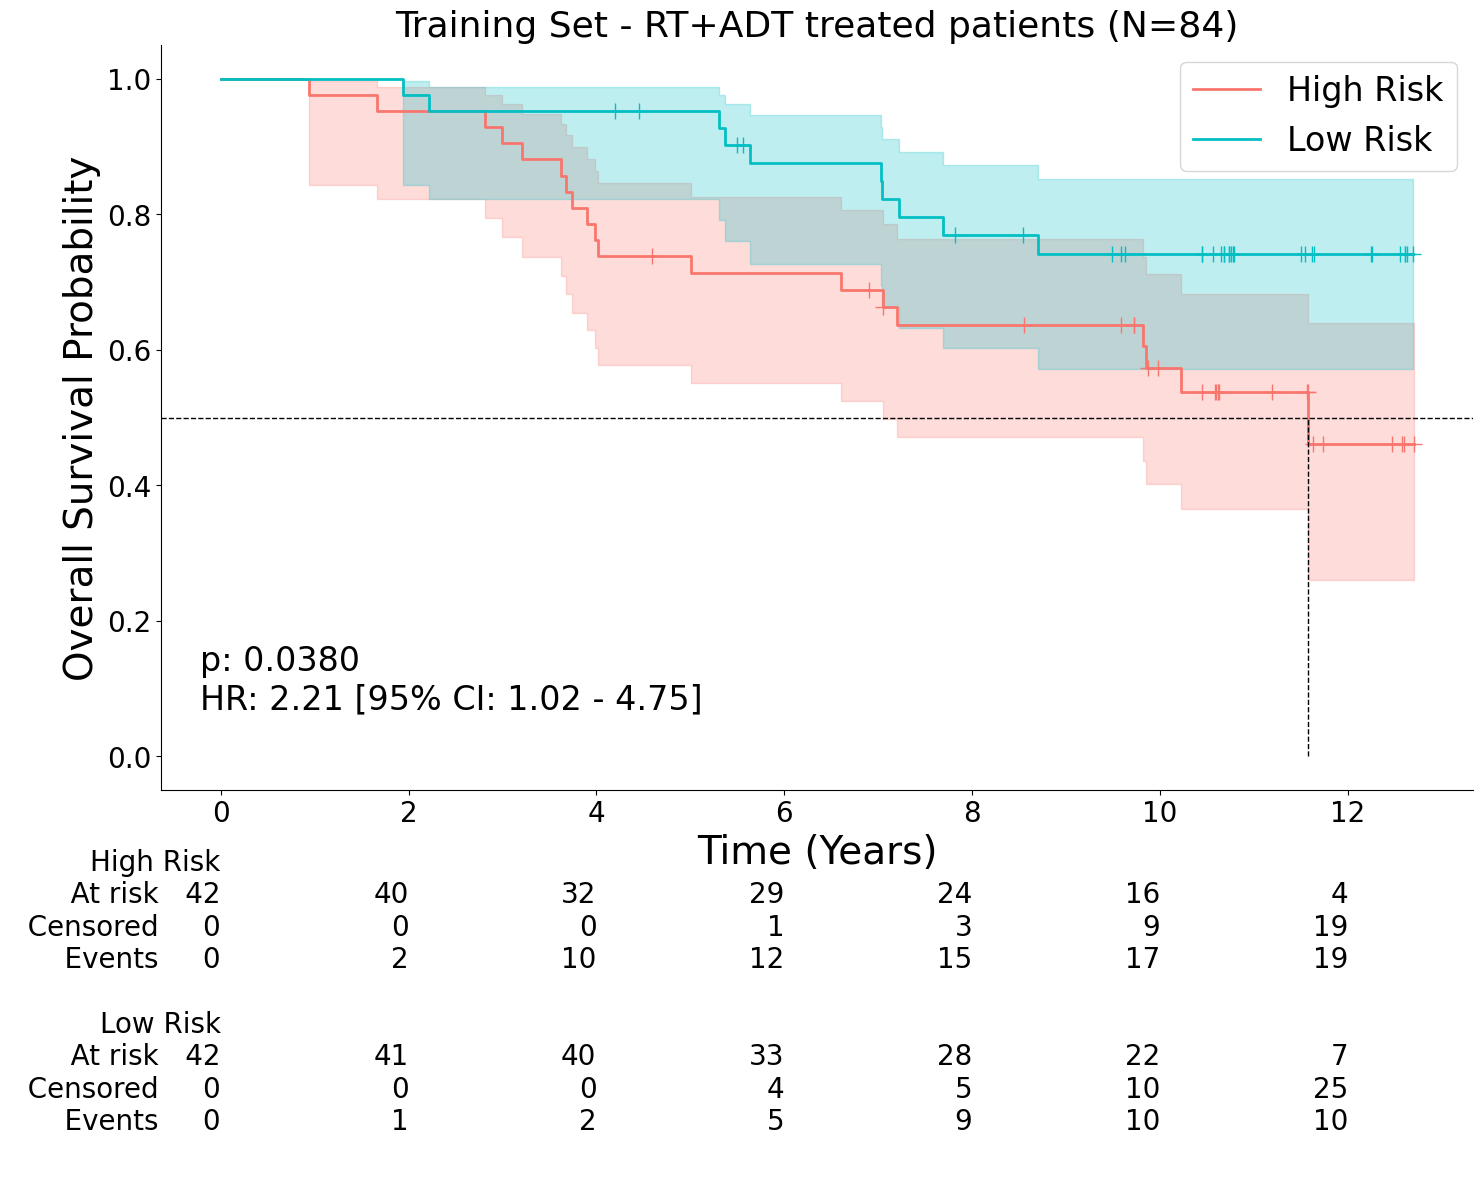

In [36]:
train_title_str = 'Training Set - RT+ADT treated patients (N={:d})'.format(len(y_training))
train_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_training_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_training, training_data_stats, train_figure_save_path, train_title_str)

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  10.09315068


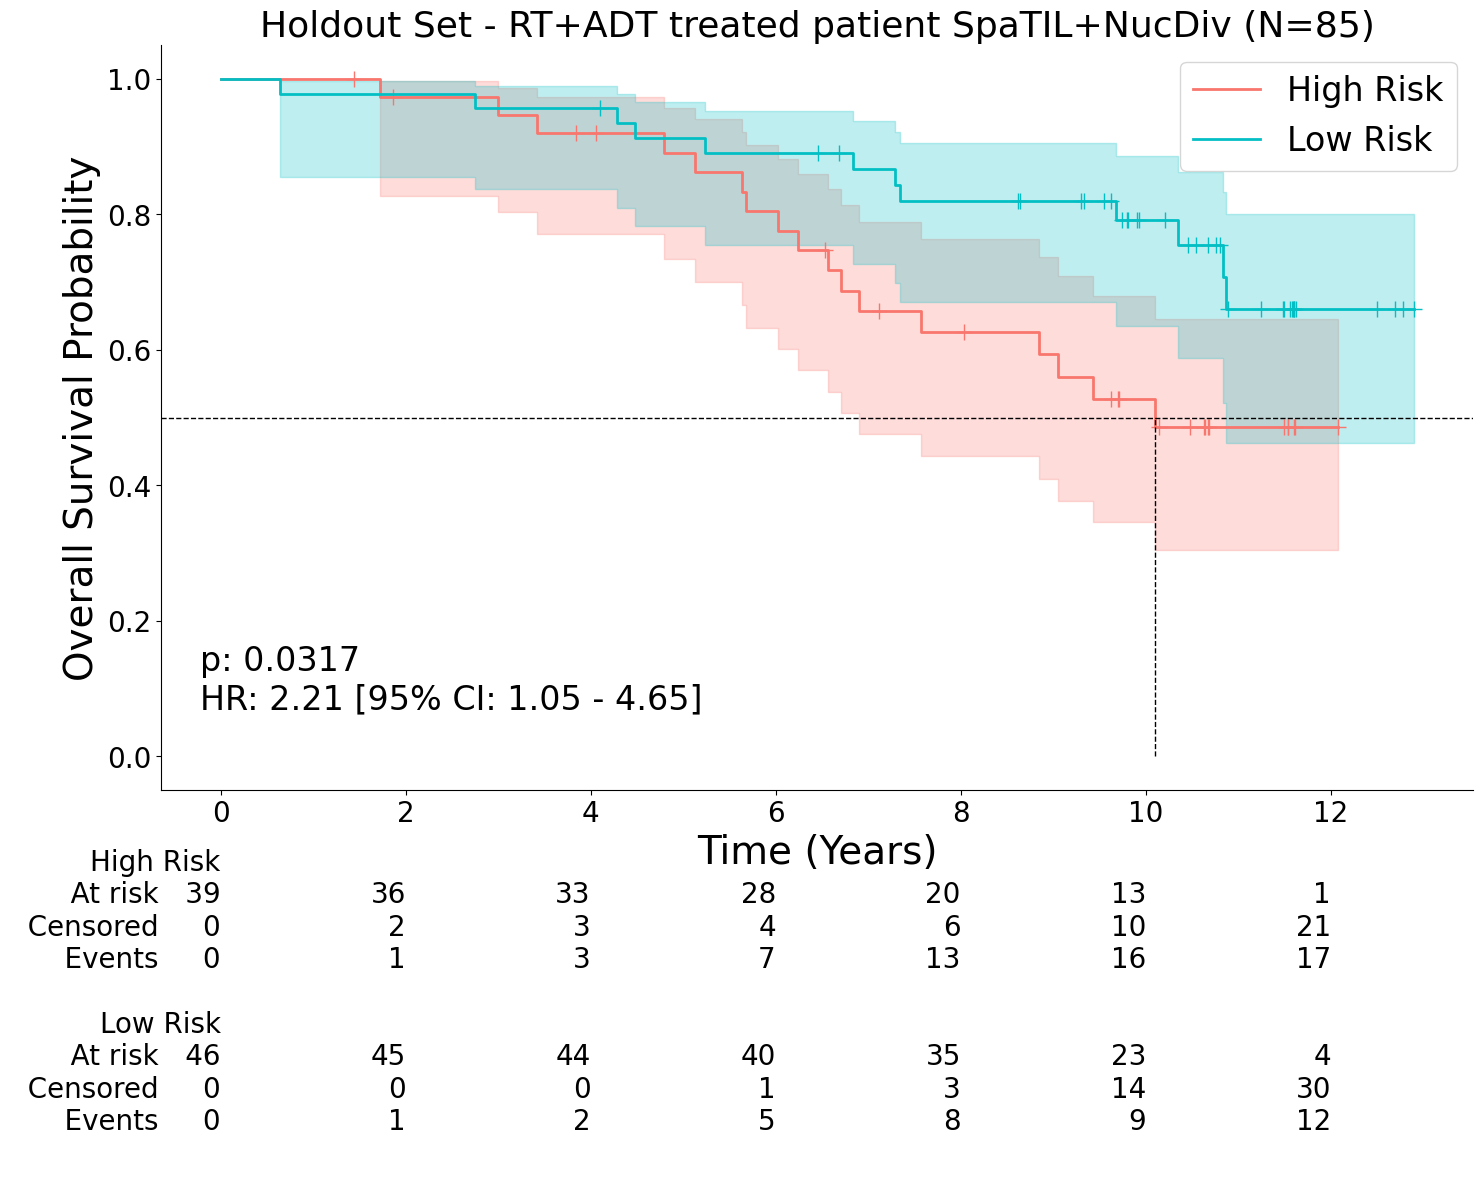

In [37]:
holdout_title_str = 'Holdout Set - RT+ADT treated patient SpaTIL+NucDiv (N={:d})'.format(len(y_holdout))
holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_holdout, holdout_data_stats, holdout_figure_save_path, holdout_title_str)

### LEG 2

In [38]:
rtog_leg_2 = rtog_features.loc[rtog_features['RX'] == 2]
rtog_leg_2 = rtog_leg_2[selected_cols]
X_holdout_chemo_arm = rtog_leg_2.drop(['patient_id', 'event', 'time', 'RX'], axis=1).reset_index(drop=True)
y_holdout_chemo_arm = rtog_leg_2[['patient_id','event', 'time', 'RX']].reset_index(drop=True)
X_holdout_chemo_arm = pd.DataFrame(scaler.transform(X_holdout_chemo_arm), columns=X_holdout_chemo_arm.columns)
y_holdout_chemo_arm_survlabel = Surv.from_dataframe('event', 'time', y_holdout_chemo_arm)

In [39]:
rtog_leg_2

,patient_id,RX,time,event,nucdiv_60,spatil_0,spatil_341,nucdiv_293,spatil_51,spatil_336,spatil_338
0,0521-237186,2,12.569863,0,0.426035,2.313596,0.000949,0.544727,1.064975e-02,0.000060,0.000013
1,0521-972417,2,12.673973,0,0.202724,0.589928,0.000230,0.564670,1.100619e-02,0.000037,0.000000
5,0521-225072,2,6.144105,1,0.492418,0.396189,0.000175,0.512276,2.196878e-03,0.000081,0.000006
6,0521-356209,2,12.649315,0,0.435147,0.268107,0.000070,0.652171,9.857500e-04,0.000110,0.000007
8,0521-898902,2,12.876712,0,0.320802,1.478261,0.000727,0.526144,5.617635e-03,0.000037,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
337,0521-099200,2,9.506849,0,0.413048,3.785388,0.001332,0.630952,2.227157e-02,0.000031,0.000000
338,0521-798508,2,9.632877,0,0.401447,3.925926,0.001300,0.657895,7.423233e-03,0.000000,0.000000
342,0521-506251,2,9.317808,0,0.653647,0.626168,0.000188,0.698198,4.333730e-03,0.000078,0.000054
346,0521-227777,2,9.731507,0,0.306286,3.107306,0.001024,0.611852,2.526193e-02,0.000013,0.000000


In [40]:
X_holdout_chemo_arm

,nucdiv_60,spatil_0,spatil_341,nucdiv_293,spatil_51,spatil_336,spatil_338
0,0.545055,0.422065,0.379184,0.299526,1.948383e-01,0.171749,0.060063
1,0.097099,0.063658,0.092074,0.381916,2.013594e-01,0.104767,0.000000
2,0.678216,0.023373,0.069949,0.165467,4.019212e-02,0.231574,0.025905
3,0.563333,-0.003260,0.027814,0.743394,1.803440e-02,0.313807,0.032003
4,0.333960,0.248371,0.290616,0.222758,1.027752e-01,0.104767,0.000000
...,...,...,...,...,...,...,...
176,0.519003,0.728099,0.532163,0.655738,4.074608e-01,0.088737,0.000000
177,0.495732,0.757322,0.519415,0.767041,1.358089e-01,0.000000,0.000000
178,1.001636,0.071193,0.075143,0.933540,7.928606e-02,0.222128,0.245755
179,0.304842,0.587104,0.409332,0.576831,4.621698e-01,0.038071,0.000000


In [41]:
chemo_arm_risk_scores = cph.predict_partial_hazard(X_holdout_chemo_arm)

In [42]:
chemo_arm_events, chemo_arm_times = y_holdout_chemo_arm['event'].values.astype(bool), y_holdout_chemo_arm['time'].values
holdout_chemo_arm_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in chemo_arm_risk_scores])
holdout_chemo_arm_survival_probs = []
holdout_chemo_arm_survival_times = []
for group_label in np.unique(holdout_chemo_arm_risk_group_labels):
    group_indices = np.where(holdout_chemo_arm_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(chemo_arm_events[group_indices], chemo_arm_times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)

In [43]:
y_holdout_chemo_arm['risk_score'] = chemo_arm_risk_scores
y_holdout_chemo_arm['risk_group'] = holdout_chemo_arm_risk_group_labels
y_holdout_chemo_arm['patient_id'] = y_holdout_chemo_arm['patient_id']
y_holdout_chemo_arm = y_holdout_chemo_arm.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout_chemo_arm

,patient_id,event,time,RX,risk_score,risk_group
0,0521-024492,0,9.430781,2,1.126931,1
1,0521-031363,0,10.636477,2,1.645949,1
2,0521-034934,0,9.490411,2,0.744510,0
3,0521-039475,0,5.018340,2,1.230733,1
4,0521-044097,0,9.536986,2,0.531119,0
...,...,...,...,...,...,...
176,0521-972417,0,12.673973,2,3.864837,1
177,0521-979111,0,4.619178,2,0.958080,0
178,0521-979162,0,12.649315,2,0.446573,0
179,0521-998850,0,10.612606,2,0.696877,0


In [44]:
# print("Metrics for RTOG treatment leg cohort")
# chemo_arm_holdout_prediction = chemo_arm_risk_scores
# chemo_arm_holdout_survival = cph.predict_survival_function(X_holdout_chemo_arm)
# times_holdout_chemo_arm = np.arange(int(np.min(y_holdout_chemo_arm_survlabel['time'])), int(np.max(y_holdout_chemo_arm_survlabel["time"])))
# survival_prediction_holdout_chemo_arm = np.asarray([[fn(t) for t in times_holdout_chemo_arm] for fn in chemo_arm_holdout_survival])
# c_index_holdout = concordance_index_censored(y_holdout_chemo_arm_survlabel["event"], y_holdout_chemo_arm_survlabel["time"], chemo_arm_holdout_prediction)
# print('C-index on Holdout set: {:.3f}'.format(c_index_holdout[0]))
# c_ipcw_holdout = concordance_index_ipcw(y_training_survlabel, y_holdout_chemo_arm_survlabel, chemo_arm_holdout_prediction)
# print('IPCW C-index on Holdout set: {:.3f}'.format(c_ipcw_holdout[0]))
# model_metrics_chemo_arm = pd.DataFrame()
# model_metrics_chemo_arm['cohort'] = ["chemo_arm"]
# model_metrics_chemo_arm['c_index_holdout'] = [c_index_holdout[0]]
# model_metrics_chemo_arm['c_index_ipcw_holdout'] = [c_ipcw_holdout[0]]
# model_metrics_chemo_arm['integrated_brier_score_holdout'] = [0]

In [45]:
y_holdout_chemo_arm

,patient_id,event,time,RX,risk_score,risk_group
0,0521-024492,0,9.430781,2,1.126931,1
1,0521-031363,0,10.636477,2,1.645949,1
2,0521-034934,0,9.490411,2,0.744510,0
3,0521-039475,0,5.018340,2,1.230733,1
4,0521-044097,0,9.536986,2,0.531119,0
...,...,...,...,...,...,...
176,0521-972417,0,12.673973,2,3.864837,1
177,0521-979111,0,4.619178,2,0.958080,0
178,0521-979162,0,12.649315,2,0.446573,0
179,0521-998850,0,10.612606,2,0.696877,0


In [46]:
LL_holdout_chemo_arm = y_holdout_chemo_arm.drop(['patient_id', 'risk_score', 'RX'], axis=1)
cph_holdout_chemo_arm = CoxPHFitter()
cph_holdout_chemo_arm.fit(LL_holdout_chemo_arm, duration_col='time', event_col='event', show_progress=False)
chemo_arm_holdout_results = cph_holdout_chemo_arm.summary
chemo_arm_holdout_p = multivariate_logrank_test(y_holdout_chemo_arm['time'], y_holdout_chemo_arm['risk_group'], y_holdout_chemo_arm['event']).p_value # holdout_results['p'].values[0]
chemo_arm_holdout_hr = chemo_arm_holdout_results['exp(coef)'].values[0]
chemo_arm_holdout_ci_lower = chemo_arm_holdout_results['exp(coef) lower 95%'].values[0]
chemo_arm_holdout_ci_upper = chemo_arm_holdout_results['exp(coef) upper 95%'].values[0]
chemo_arm_holdout_log_likelihood = cph_holdout_chemo_arm.log_likelihood_
model_metrics_chemo_arm = pd.DataFrame()
model_metrics_chemo_arm['holdout_p_value'] = [chemo_arm_holdout_p]
model_metrics_chemo_arm['holdout_hazard_ratio'] = [chemo_arm_holdout_hr]
model_metrics_chemo_arm['holdout_hr_ci_lower'] = [chemo_arm_holdout_ci_lower]
model_metrics_chemo_arm['holdout_hr_ci_upper'] = [chemo_arm_holdout_ci_upper]
model_metrics_chemo_arm['holdout_log_likelihood'] = [chemo_arm_holdout_log_likelihood]
model_metrics_chemo_arm['holdout_parameters'] = [cph_holdout_chemo_arm.params_.shape[0]]
chemo_arm_holdout_data_stats = (chemo_arm_holdout_p, chemo_arm_holdout_hr, chemo_arm_holdout_ci_lower, chemo_arm_holdout_ci_upper)

In [47]:
cph_holdout_chemo_arm.print_summary()

<lifelines.CoxPHFitter: fitted with 181 total observations, 128 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 181
number of events observed = 53
   partial log-likelihood = -249.80
         time fit was run = 2024-05-20 18:20:20 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.05       1.05       0.28            -0.50             0.59                 0.61                 1.80

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 0.17 0.87       0.20
---
Concordance = 0.49
Partial AIC = 501.59
log-likelihood ratio test = 0.03 on 1 df
-log2(p) of ll-ratio test = 0.20

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  12.19178082


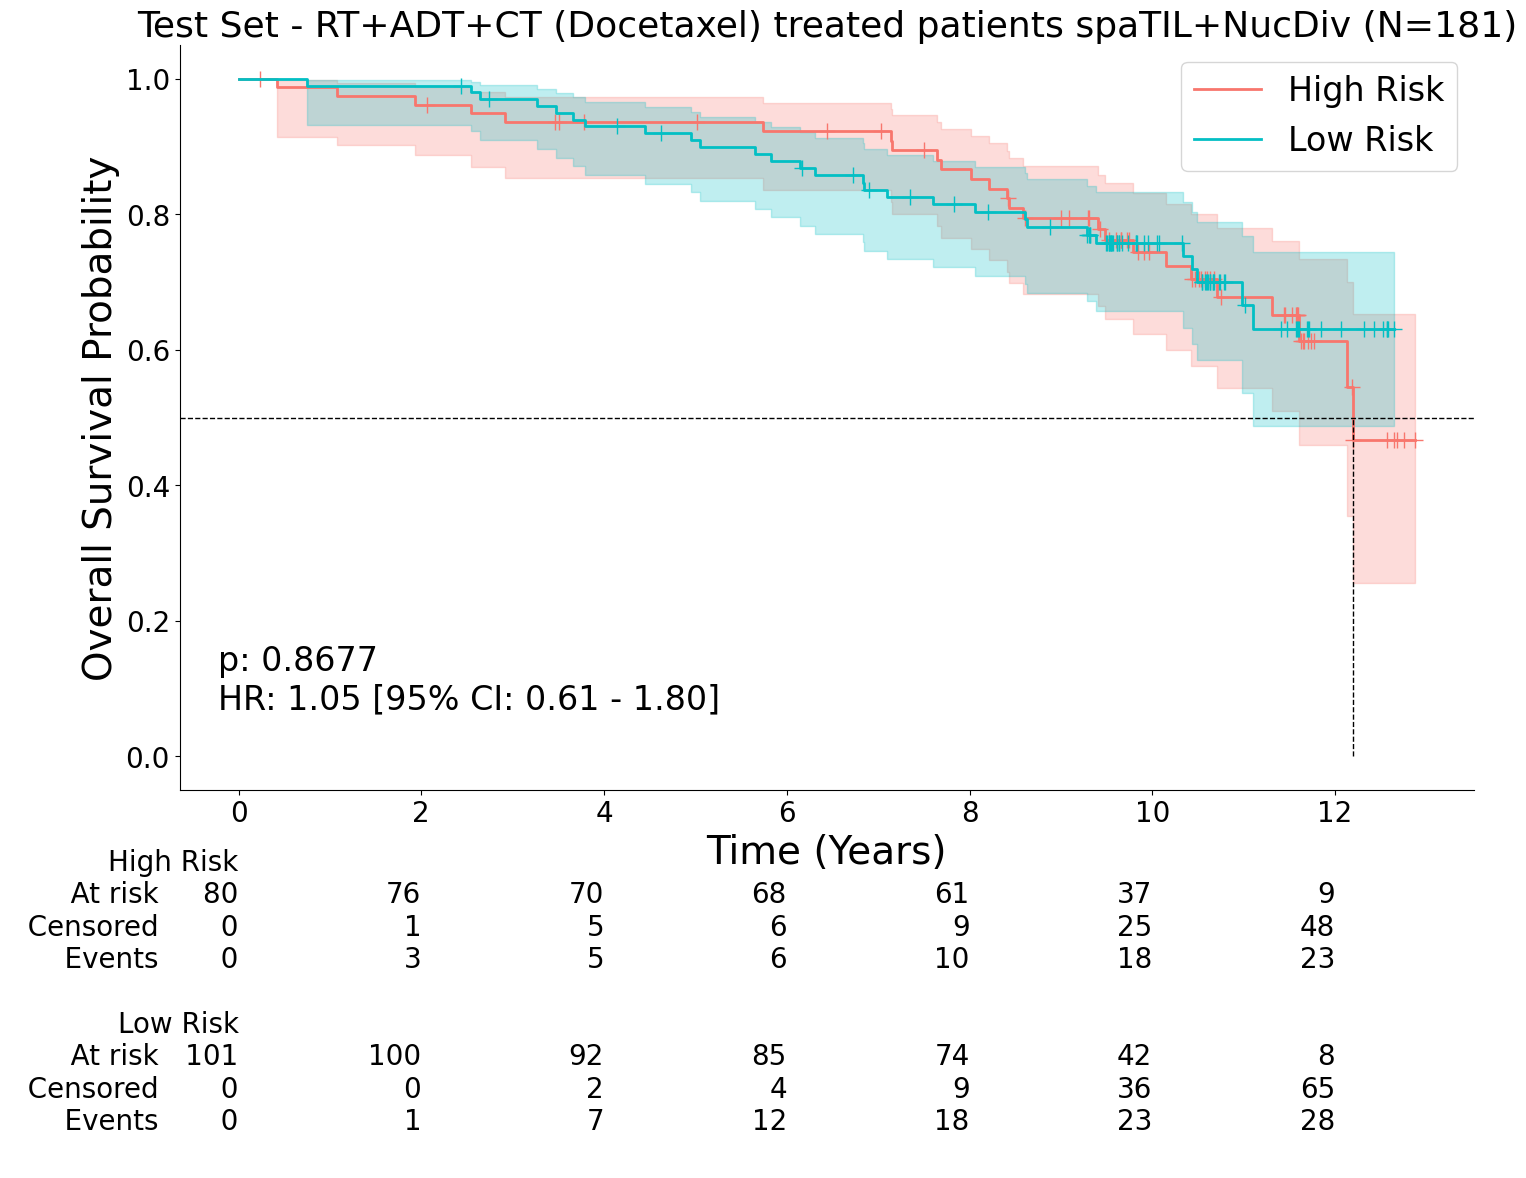

In [48]:
chemo_arm_holdout_title_str = 'Test Set - RT+ADT+CT (Docetaxel) treated patients spaTIL+NucDiv (N={:d})'.format(len(y_holdout_chemo_arm))
chemo_arm_holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_chemo_arm_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}.png'
plot_km_curve_lifelines(y_holdout_chemo_arm, chemo_arm_holdout_data_stats, chemo_arm_holdout_figure_save_path, chemo_arm_holdout_title_str)

#### Biomarker - RT+ADT vs RT+ADT+CT

In [49]:
chemo_favorable_risk = y_holdout_chemo_arm[y_holdout_chemo_arm['risk_group'] == 0]
chemo_favorable_risk['chemo'] = 1
no_chemo_favorable_risk = y_holdout[y_holdout['risk_group'] == 0]
no_chemo_favorable_risk['chemo'] = 0
favorable_risk = pd.concat([chemo_favorable_risk, no_chemo_favorable_risk])

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/1806258047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_favorable_risk['chemo'] = 1
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/1806258047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_favorable_risk['chemo'] = 0


In [50]:
favorable_risk

,patient_id,event,time,RX,risk_score,risk_group,chemo
2,0521-034934,0,9.490411,2.0,0.744510,0,1
4,0521-044097,0,9.536986,2.0,0.531119,0,1
6,0521-049529,1,2.539726,2.0,0.668165,0,1
8,0521-055304,0,12.430137,2.0,0.653713,0,1
9,0521-056372,1,8.605225,2.0,0.443301,0,1
...,...,...,...,...,...,...,...
77,0521-907614,1,0.637615,NaN,0.396884,0,0
78,0521-914243,1,5.229695,NaN,0.472869,0,0
79,0521-915221,0,9.794521,NaN,0.490745,0,0
82,0521-923895,0,10.453567,NaN,0.754107,0,0


In [51]:
LL_holdout_chemo_arm = favorable_risk.drop(['patient_id', 'risk_group', 'risk_score', 'RX'], axis=1)
cph_holdout_chemo_arm = CoxPHFitter()
cph_holdout_chemo_arm.fit(LL_holdout_chemo_arm, duration_col='time', event_col='event', show_progress=False)

chemo_arm_holdout_results = cph_holdout_chemo_arm.summary
chemo_arm_holdout_p = multivariate_logrank_test(favorable_risk['time'], favorable_risk['chemo'], favorable_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
chemo_arm_holdout_hr = chemo_arm_holdout_results['exp(coef)'].values[0]
chemo_arm_holdout_ci_lower = chemo_arm_holdout_results['exp(coef) lower 95%'].values[0]
chemo_arm_holdout_ci_upper = chemo_arm_holdout_results['exp(coef) upper 95%'].values[0]
chemo_arm_holdout_log_likelihood = cph_holdout_chemo_arm.log_likelihood_
model_metrics_chemo_arm['holdout_p_value'] = [chemo_arm_holdout_p]
model_metrics_chemo_arm['holdout_hazard_ratio'] = [chemo_arm_holdout_hr]
model_metrics_chemo_arm['holdout_hr_ci_lower'] = [chemo_arm_holdout_ci_lower]
model_metrics_chemo_arm['holdout_hr_ci_upper'] = [chemo_arm_holdout_ci_upper]
model_metrics_chemo_arm['holdout_log_likelihood'] = [chemo_arm_holdout_log_likelihood]
model_metrics_chemo_arm['holdout_parameters'] = [cph_holdout_chemo_arm.params_.shape[0]]

chemo_arm_holdout_data_stats = (chemo_arm_holdout_p, chemo_arm_holdout_hr, chemo_arm_holdout_ci_lower, chemo_arm_holdout_ci_upper)

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  inf


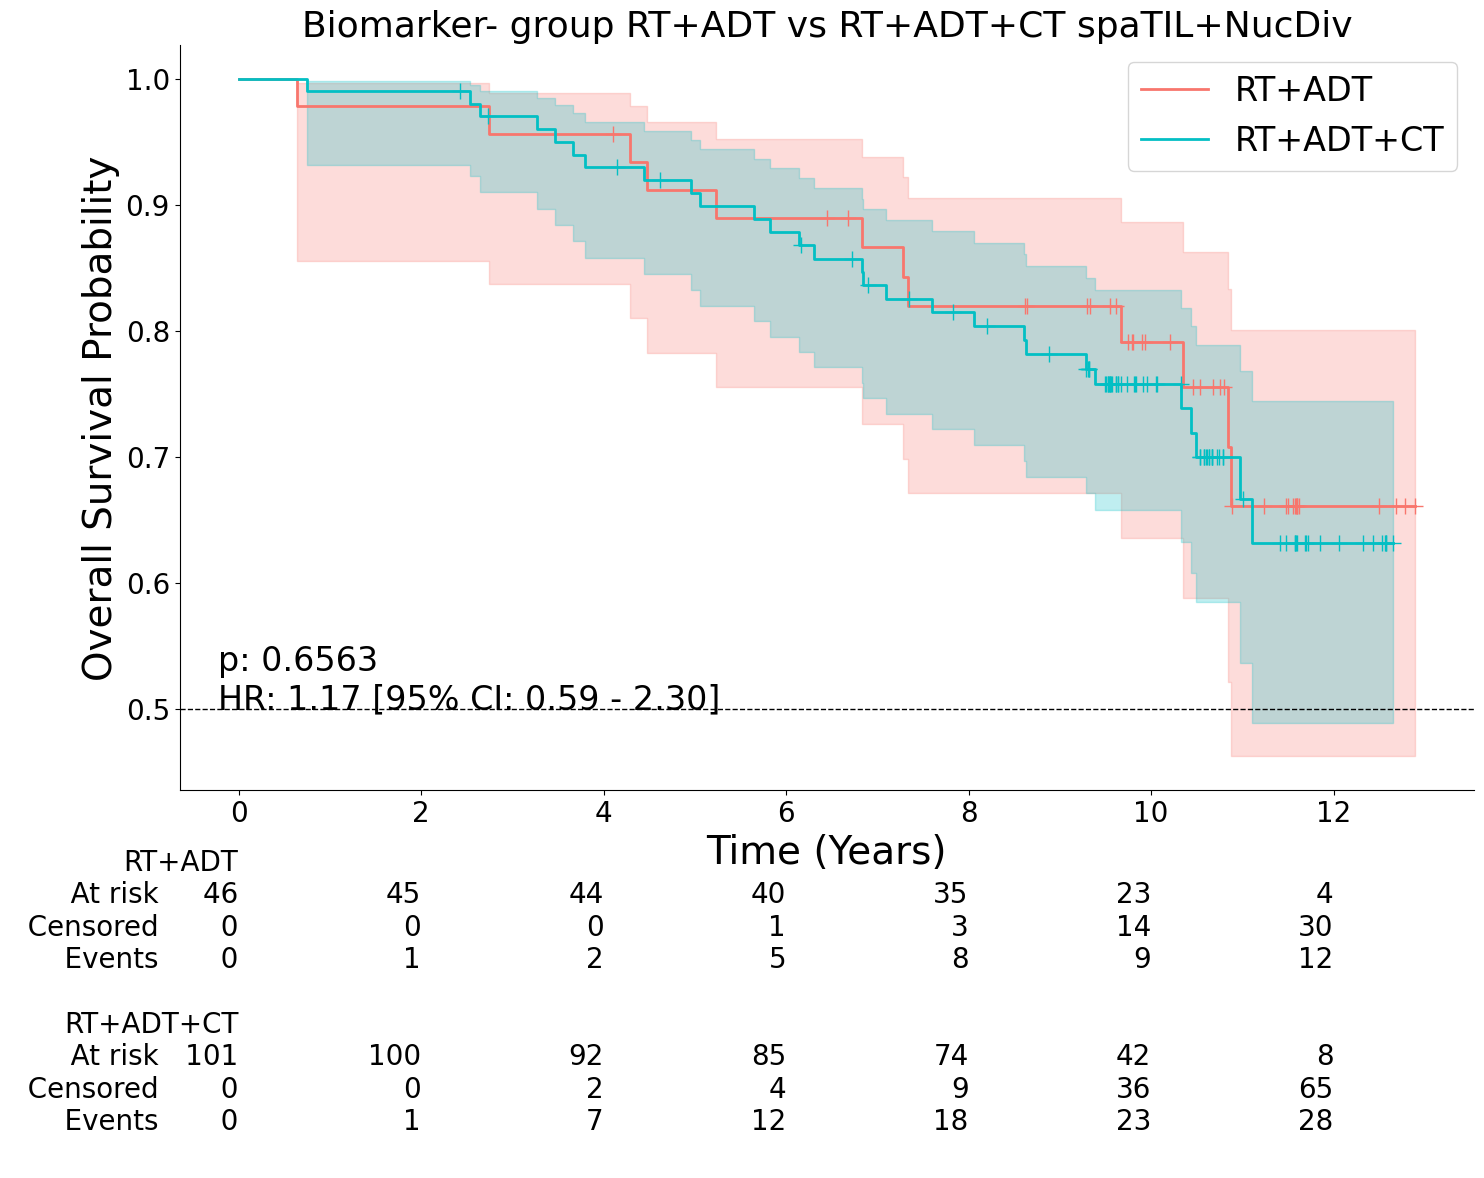

In [52]:
plot_km_same_risk_group(no_chemo_favorable_risk, chemo_favorable_risk, chemo_arm_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/favorable_risk_both_legs_km.png', "Biomarker- group RT+ADT vs RT+ADT+CT spaTIL+NucDiv")

#### Biomarker + RT+ADT vs RT+ADT+CT

In [53]:
chemo_bad_risk = y_holdout_chemo_arm[y_holdout_chemo_arm['risk_group'] == 1]
no_chemo_bad_risk = y_holdout[y_holdout['risk_group'] == 1]
chemo_bad_risk['chemo'] = 1
no_chemo_bad_risk['chemo'] = 0
bad_risk = pd.concat([chemo_bad_risk, no_chemo_bad_risk])

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/1888853012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_bad_risk['chemo'] = 1
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/1888853012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_bad_risk['chemo'] = 0


In [54]:
LL_holdout_chemo_arm = bad_risk.drop(['patient_id', 'risk_group', 'risk_score', 'RX'], axis=1)
cph_holdout_chemo_arm = CoxPHFitter()
cph_holdout_chemo_arm.fit(LL_holdout_chemo_arm, duration_col='time', event_col='event', show_progress=False)

chemo_arm_holdout_results = cph_holdout_chemo_arm.summary
chemo_arm_holdout_p = multivariate_logrank_test(bad_risk['time'], bad_risk['chemo'], bad_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
chemo_arm_holdout_hr = chemo_arm_holdout_results['exp(coef)'].values[0]
chemo_arm_holdout_ci_lower = chemo_arm_holdout_results['exp(coef) lower 95%'].values[0]
chemo_arm_holdout_ci_upper = chemo_arm_holdout_results['exp(coef) upper 95%'].values[0]
chemo_arm_holdout_log_likelihood = cph_holdout_chemo_arm.log_likelihood_
model_metrics_chemo_arm['holdout_p_value'] = [chemo_arm_holdout_p]
model_metrics_chemo_arm['holdout_hazard_ratio'] = [chemo_arm_holdout_hr]
model_metrics_chemo_arm['holdout_hr_ci_lower'] = [chemo_arm_holdout_ci_lower]
model_metrics_chemo_arm['holdout_hr_ci_upper'] = [chemo_arm_holdout_ci_upper]
model_metrics_chemo_arm['holdout_log_likelihood'] = [chemo_arm_holdout_log_likelihood]
model_metrics_chemo_arm['holdout_parameters'] = [cph_holdout_chemo_arm.params_.shape[0]]

chemo_arm_holdout_data_stats = (chemo_arm_holdout_p, chemo_arm_holdout_hr, chemo_arm_holdout_ci_lower, chemo_arm_holdout_ci_upper)

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/2559867318.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  12.19178082
High risk median survival time:  10.09315068


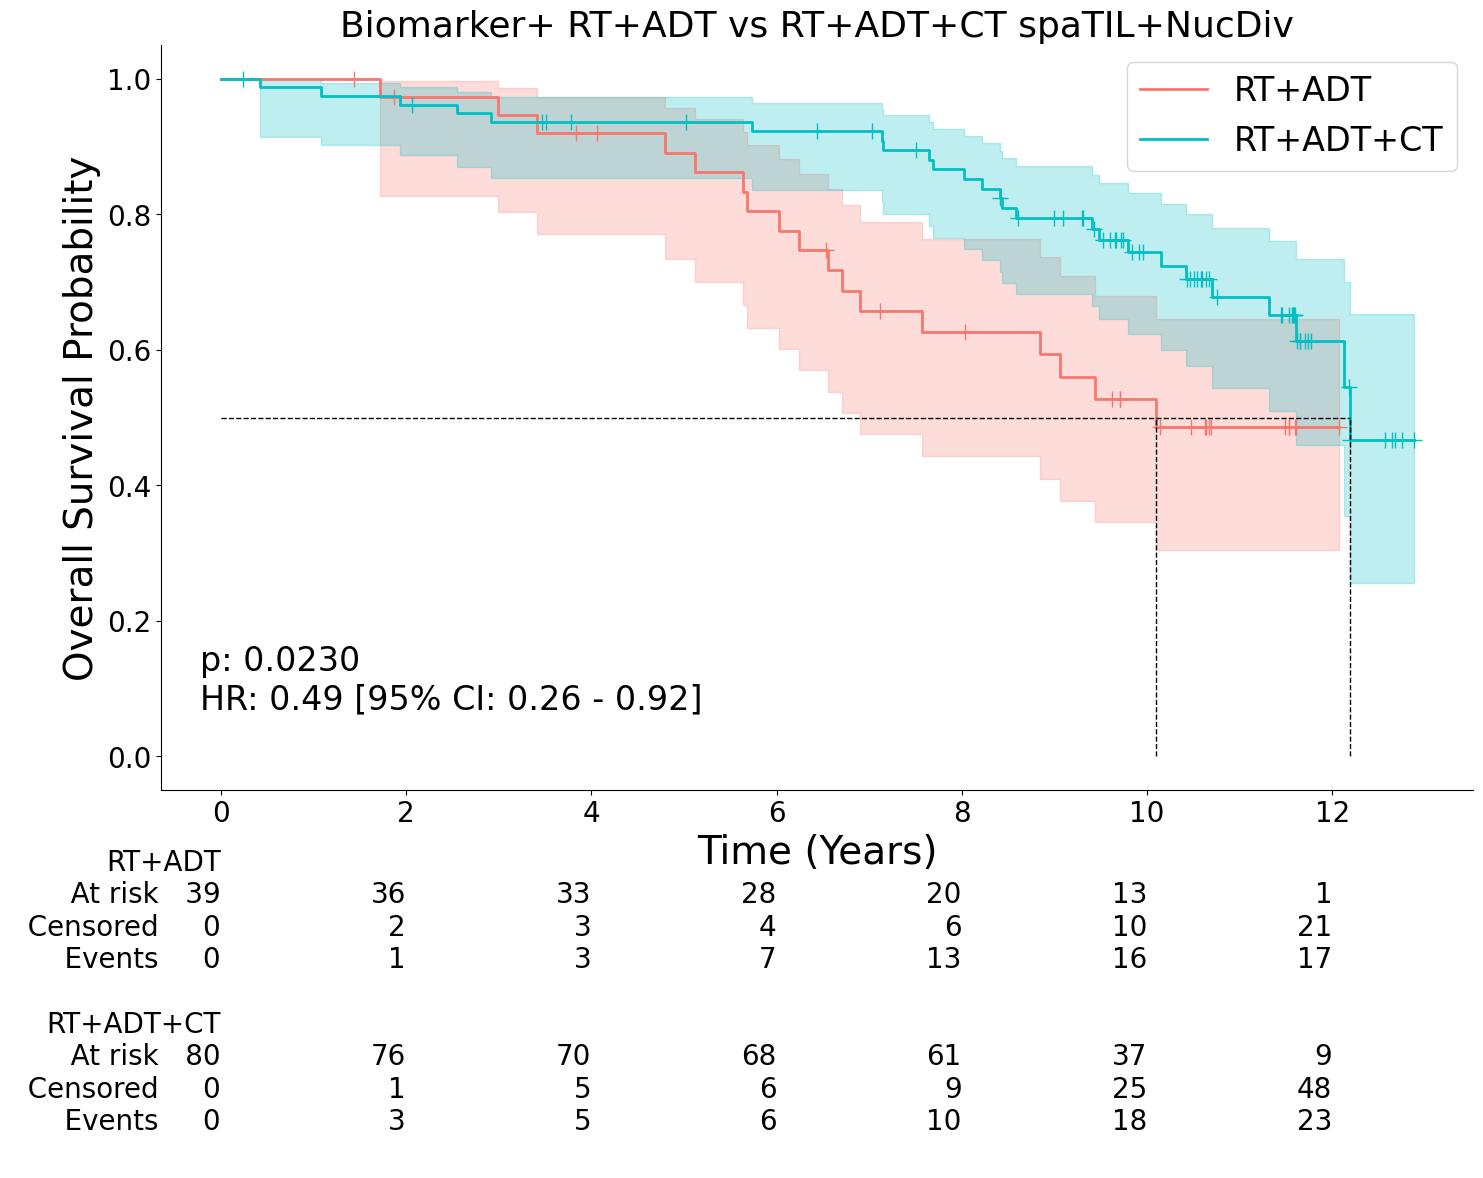

In [55]:
plot_km_same_risk_group(no_chemo_bad_risk, chemo_bad_risk, chemo_arm_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/bad_risk_both_legs_km.png', "Biomarker+ RT+ADT vs RT+ADT+CT spaTIL+NucDiv")

#### Interaction term analysis

In [60]:
interaction_term_test_df = pd.concat([no_chemo_bad_risk, chemo_bad_risk, no_chemo_favorable_risk, chemo_favorable_risk])
interaction_term_test_df['interaction_term'] = interaction_term_test_df['chemo'] * interaction_term_test_df['risk_score']
interaction_term_cox = CoxPHFitter()
interaction_term_cox.fit(interaction_term_test_df.drop(['patient_id', 'risk_group', 'RX'], axis=1), duration_col='time', event_col='event', show_progress=False)
interaction_term_cox_results = interaction_term_cox.summary

In [61]:
interaction_term_cox_results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
risk_score,0.515867,1.675090,0.211203,0.101916,0.929818,1.107290,2.534048,0.0,2.442511,0.014585,6.099322
chemo,0.401287,1.493746,0.395257,-0.373403,1.175978,0.688388,3.241310,0.0,1.015256,0.309984,1.689735
interaction_term,-0.510863,0.599978,0.226097,-0.954005,-0.067721,0.385195,0.934522,0.0,-2.259484,0.023853,5.389666


#### Net benefit analysis

In [62]:
benefits = calculate_survival_benefit(no_chemo_favorable_risk, chemo_favorable_risk)
print("Survival Benefits at specified time points for biomarker - patients:", benefits)

Survival Benefits at specified time points: {1: 1.1838140335773129, 3: 1.357527057053587, 5: -0.29032901501102604, 7: -3.0191788598040614, 10: -3.3365594540144983}


In [63]:
benefits = calculate_survival_benefit(no_chemo_bad_risk, chemo_bad_risk)
print("Survival Benefits at specified time points for biomarker + patients:", benefits)

Survival Benefits at specified time points: {1: -1.2658227848101333, 3: -1.0266118883706987, 5: 4.551787234436288, 7: 26.529339940844544, 10: 21.68559664628641}


In [67]:
net_benefit_df = interaction_term_test_df[['event', 'time', 'risk_group']]

In [68]:
net_benefit_df

,event,time,risk_group
0,0,7.111790,1
1,0,11.534247,1
2,0,9.703099,1
3,0,6.528767,1
6,1,9.054772,1
...,...,...,...
173,1,0.747743,0
174,0,10.739883,0
177,0,4.619178,0
178,0,12.649315,0


In [69]:
cox_dca = CoxPHFitter()
cox_dca.fit(net_benefit_df, duration_col='time', event_col='event', show_progress=False)

<lifelines.CoxPHFitter: fitted with 266 total observations, 184 right-censored observations>

In [70]:
cox_dca.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
risk_group,0.313003,1.367525,0.221085,-0.120317,0.746322,0.88664,2.109227,0.0,1.415755,0.156847,2.672568


In [72]:
cph_pred_vals = cox_dca.predict_survival_function(net_benefit_df[['risk_group']], times=[10])

In [74]:
net_benefit_df['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0,:]]

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/3530386936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net_benefit_df['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0,:]]


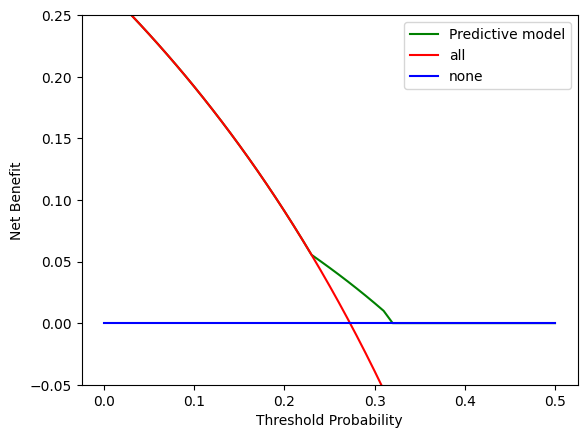

In [75]:
stdca_coxph_results = dca(data=net_benefit_df, outcome='event', modelnames=['Predictive model'], thresholds=np.arange(0,0.51,0.01), time=10, time_to_outcome_col='time')

plot_graphs(plot_df=stdca_coxph_results, graph_type='net_benefit', y_limits=[-0.05, 0.25], color_names=['green', 'red', 'blue'], show_grid=False, dpi=300)

In [76]:
net_benefit_df_no_chemo = interaction_term_test_df[interaction_term_test_df['chemo'] == 0]

In [78]:
net_benefit_df_no_chemo = net_benefit_df_no_chemo[['event', 'time', 'risk_group']]

In [80]:
cox_dca = CoxPHFitter()
cox_dca.fit(net_benefit_df_no_chemo, duration_col='time', event_col='event', show_progress=False)

<lifelines.CoxPHFitter: fitted with 85 total observations, 56 right-censored observations>

In [81]:
cph_pred_vals = cox_dca.predict_survival_function(net_benefit_df_no_chemo[['risk_group']], times=[10])

In [82]:
net_benefit_df_no_chemo['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0,:]]

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/805616953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net_benefit_df_no_chemo['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0,:]]


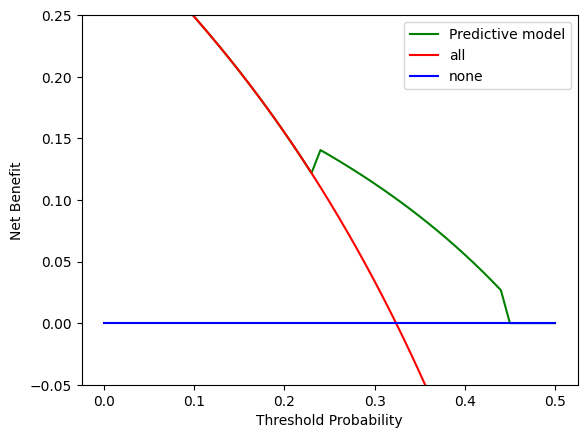

In [83]:
stdca_coxph_results = dca(data=net_benefit_df_no_chemo, outcome='event', modelnames=['Predictive model'], thresholds=np.arange(0,0.51,0.01), time=10, time_to_outcome_col='time')

plot_graphs(plot_df=stdca_coxph_results, graph_type='net_benefit', y_limits=[-0.05, 0.25], color_names=['green', 'red', 'blue'], show_grid=False, dpi=300)

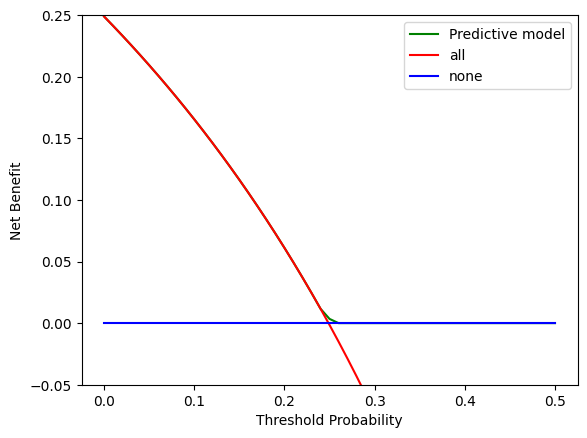

In [84]:
net_benefit_df_chemo = interaction_term_test_df[interaction_term_test_df['chemo'] == 1]
net_benefit_df_chemo = net_benefit_df_chemo[['event', 'time', 'risk_group']]
cox_dca = CoxPHFitter()
cox_dca.fit(net_benefit_df_chemo, duration_col='time', event_col='event', show_progress=False)
cph_pred_vals = cox_dca.predict_survival_function(net_benefit_df_chemo[['risk_group']], times=[10])
net_benefit_df_chemo['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0,:]]
stdca_coxph_results = dca(data=net_benefit_df_chemo, outcome='event', modelnames=['Predictive model'], thresholds=np.arange(0,0.51,0.01), time=10, time_to_outcome_col='time')
plot_graphs(plot_df=stdca_coxph_results, graph_type='net_benefit', y_limits=[-0.05, 0.25], color_names=['green', 'red', 'blue'], show_grid=False, dpi=300)

#### Multivariable analysis

In [89]:
clinical_data = pd.read_csv('/Users/srmedinac/Library/CloudStorage/OneDrive-EmoryUniversity/Documents/scripts/RTOG_0521_clinical_data_scripts/RTOG_0521_clinical_data.csv')

In [90]:
clinical_data = clinical_data.rename(columns={'cn_deidentified': 'patient_id'})
clinical_data = clinical_data[['patient_id', 'age', 'race', 'gleason', 'psa', 't_stage']]
multivar_analysis_df = interaction_term_test_df.merge(clinical_data, on='patient_id', how='left')

In [92]:
multivar_analysis_df.drop(columns=['risk_score', 'RX', 'interaction_term'], inplace=True)

In [93]:
multivar_analysis_all_patients = multivar_analysis_df.drop(columns=['chemo'], axis=1)

In [94]:
multivar_analysis_all_patients

,patient_id,event,time,risk_group,age,race,gleason,psa,t_stage
0,0521-002001,0,7.111790,1,80,5,9,16.80,3
1,0521-029609,0,11.534247,1,67,5,8,11.00,8
2,0521-035384,0,9.703099,1,61,5,9,9.62,6
3,0521-046445,0,6.528767,1,62,5,9,12.00,7
4,0521-090468,1,9.054772,1,69,5,9,4.32,8
...,...,...,...,...,...,...,...,...,...
261,0521-962433,1,0.747743,0,66,5,10,7.10,3
262,0521-962717,0,10.739883,0,64,5,9,28.63,9
263,0521-979111,0,4.619178,0,69,5,8,17.16,9
264,0521-979162,0,12.649315,0,59,5,8,39.51,8


In [98]:
multivar_analysis_all_patients.drop(columns=['age', 'race'], inplace=True)
multivar_analysis_all_patients['t_stage'] = np.where(multivar_analysis_all_patients['t_stage'] > 7, 1, 0)

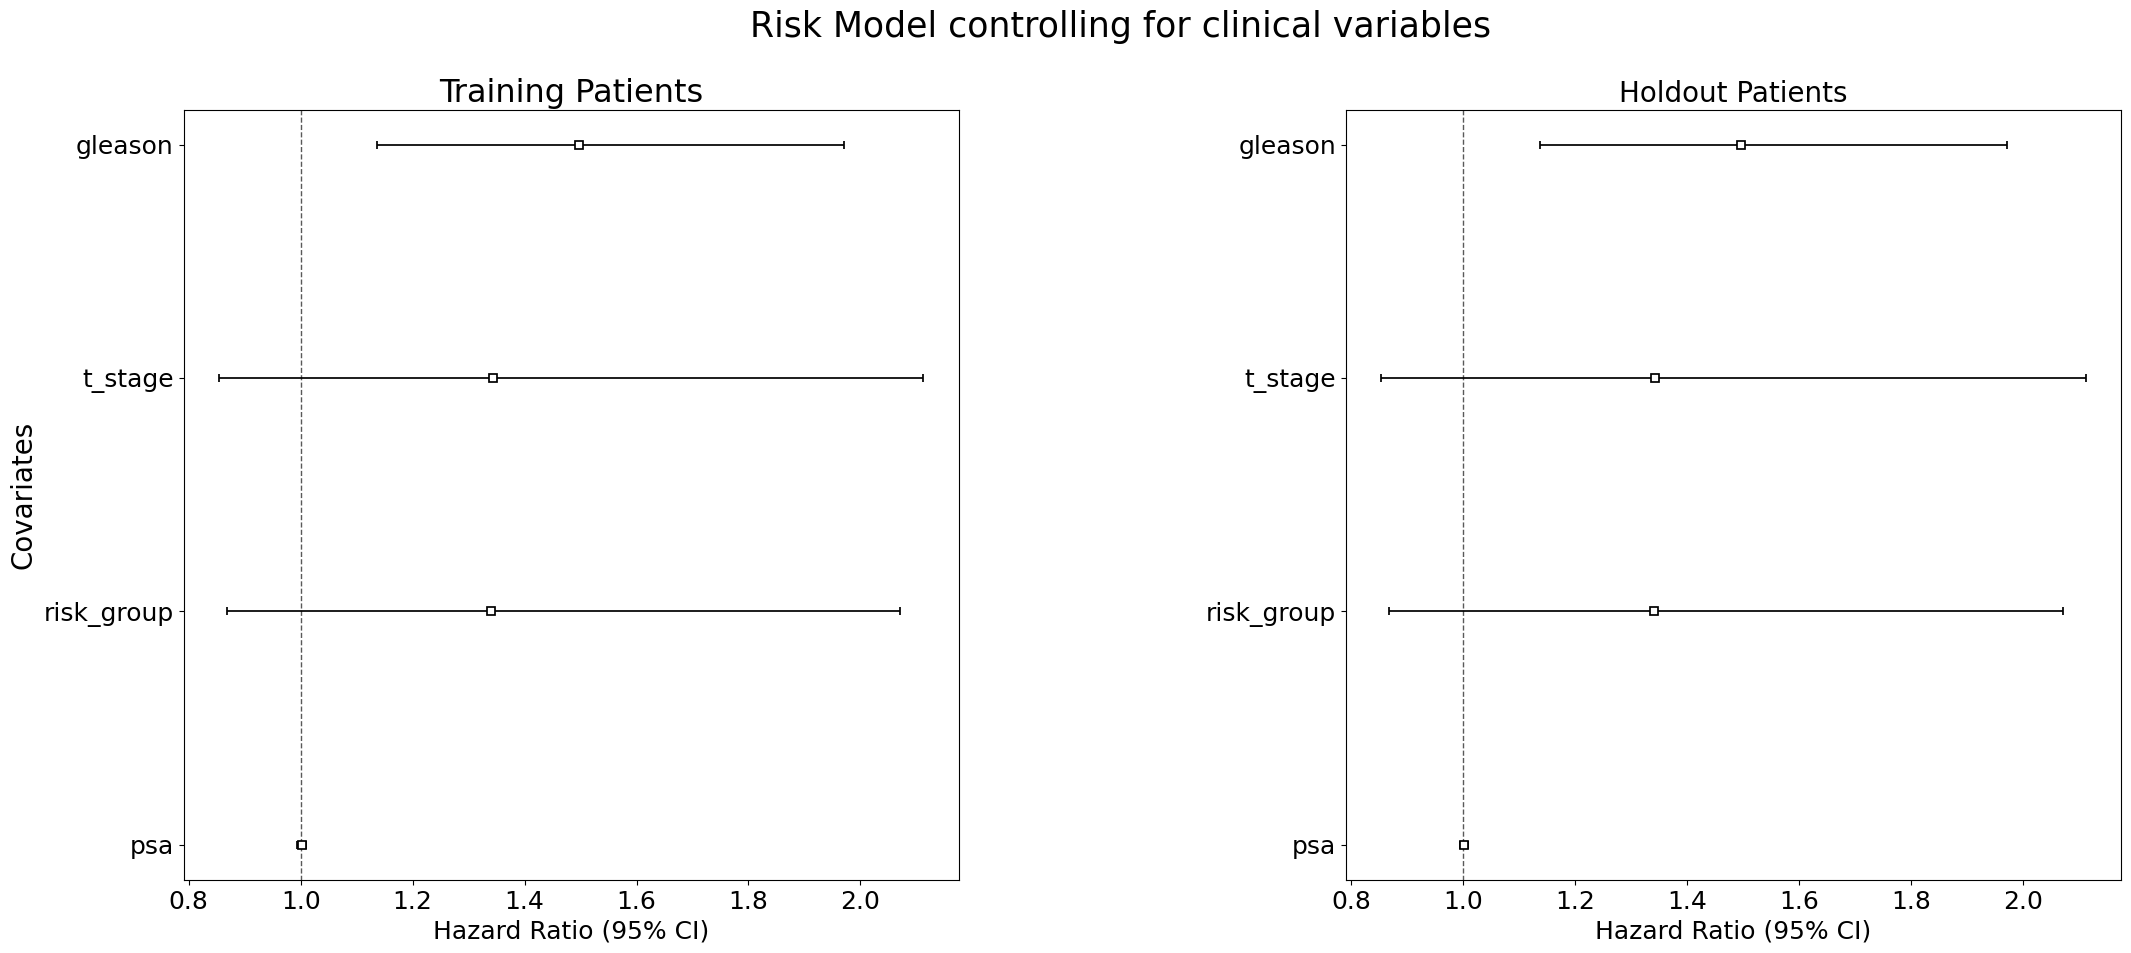

<lifelines.CoxPHFitter: fitted with 266 total observations, 184 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 266
number of events observed = 82
   partial log-likelihood = -414.51
         time fit was run = 2024-05-20 20:18:37 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.29       1.34       0.22            -0.14             0.73                 0.87                 2.07
gleason      0.40       1.50       0.14             0.13             0.68                 1.14                 1.97
psa          0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
t_stage      0.29       1.34       0.23            -0.16             0.75                 0.85                 2.11

             cmp to    z      p   -log2(p)
covariate                                 
risk_group     0.00 1.32   0.19       2.42
gleason        0.00 2.87 <0.005       7.95
psa            0.00 0.43   0.67       0.59
t_stage        0.00 1.28   0.20       2.31
---
Concordance = 0.63
Partial AIC = 837.01
log-likelihood ratio test = 11.99 on 4 df
-log2(p) of ll-ratio test = 5.84

In [99]:
holdout_results, cph_holdout_adjusted_risk = get_multivariate_coxph_results(multivar_analysis_all_patients)
plt_title = 'Risk Model controlling for clinical variables'
save_path = ''
plot_n_save_adjusted_hazard(cph_holdout_adjusted_risk, cph_holdout_adjusted_risk, multivar_analysis_all_patients, multivar_analysis_all_patients, save_path, plt_title)
cph_holdout_adjusted_risk.print_summary()

In [100]:
multivar_analysis_df_only_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 1]

In [102]:
multivar_analysis_df_only_chemo

,patient_id,event,time,risk_group,chemo,age,race,gleason,psa,t_stage
39,0521-024492,0,9.430781,1,1,68,5,10,8.70,9
40,0521-031363,0,10.636477,1,1,71,5,9,25.60,5
41,0521-039475,0,5.018340,1,1,69,3,9,11.16,5
42,0521-047316,1,8.213699,1,1,69,5,9,1.50,10
43,0521-051253,0,3.506849,1,1,74,5,8,4.90,6
...,...,...,...,...,...,...,...,...,...,...
261,0521-962433,1,0.747743,0,1,66,5,10,7.10,3
262,0521-962717,0,10.739883,0,1,64,5,9,28.63,9
263,0521-979111,0,4.619178,0,1,69,5,8,17.16,9
264,0521-979162,0,12.649315,0,1,59,5,8,39.51,8


In [103]:
multivar_analysis_df_only_chemo.drop(columns=['age', 'race', 'chemo'], inplace=True)
multivar_analysis_df_only_chemo['t_stage'] = np.where(multivar_analysis_df_only_chemo['t_stage'] > 7, 1, 0)

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/4186514729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_only_chemo.drop(columns=['age', 'race', 'chemo'], inplace=True)
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/4186514729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_only_chemo['t_stage'] = np.where(multivar_analysis_df_only_chemo['t_stage'] > 7, 1, 0)


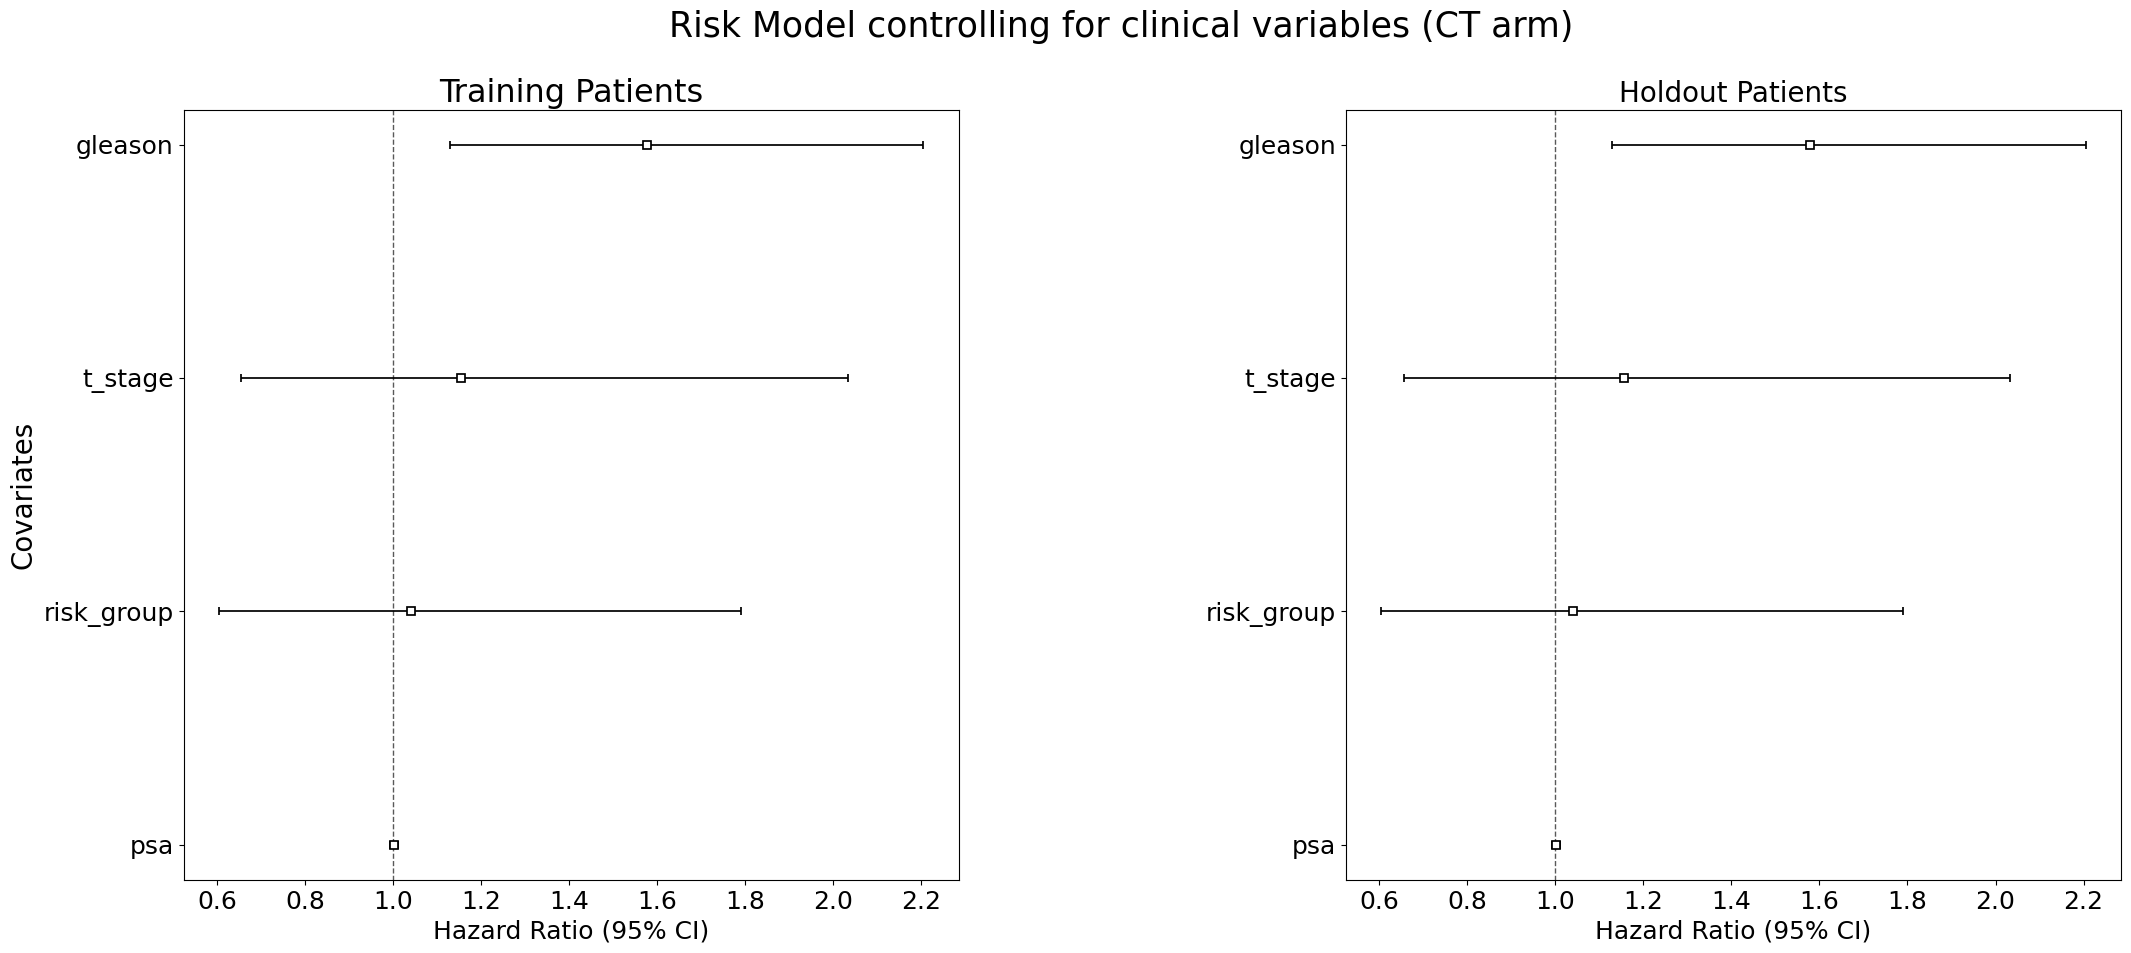

<lifelines.CoxPHFitter: fitted with 181 total observations, 128 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 181
number of events observed = 53
   partial log-likelihood = -245.99
         time fit was run = 2024-05-20 20:20:26 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.04       1.04       0.28            -0.50             0.58                 0.60                 1.79
gleason      0.46       1.58       0.17             0.12             0.79                 1.13                 2.21
psa          0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
t_stage      0.14       1.15       0.29            -0.42             0.71                 0.66                 2.03

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 0.14 0.89       0.17
gleason        0.00 2.67 0.01       7.04
psa            0.00 0.34 0.73       0.45
t_stage        0.00 0.50 0.62       0.69
---
Concordance = 0.63
Partial AIC = 499.97
log-likelihood ratio test = 7.65 on 4 df
-log2(p) of ll-ratio test = 3.25

In [104]:
holdout_results, cph_holdout_adjusted_risk = get_multivariate_coxph_results(multivar_analysis_df_only_chemo)
plt_title = 'Risk Model controlling for clinical variables (CT arm)'
save_path = ''
plot_n_save_adjusted_hazard(cph_holdout_adjusted_risk, cph_holdout_adjusted_risk, multivar_analysis_df_only_chemo, multivar_analysis_df_only_chemo, save_path, plt_title)
cph_holdout_adjusted_risk.print_summary()

In [105]:
multivar_analysis_df_no_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 0]
multivar_analysis_df_no_chemo.drop(columns=['age', 'race', 'chemo'], inplace=True)
multivar_analysis_df_no_chemo['t_stage'] = np.where(multivar_analysis_df_no_chemo['t_stage'] > 7, 1, 0)

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/1309255233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_no_chemo.drop(columns=['age', 'race', 'chemo'], inplace=True)
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_19840/1309255233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_no_chemo['t_stage'] = np.where(multivar_analysis_df_no_chemo['t_stage'] > 7, 1, 0)


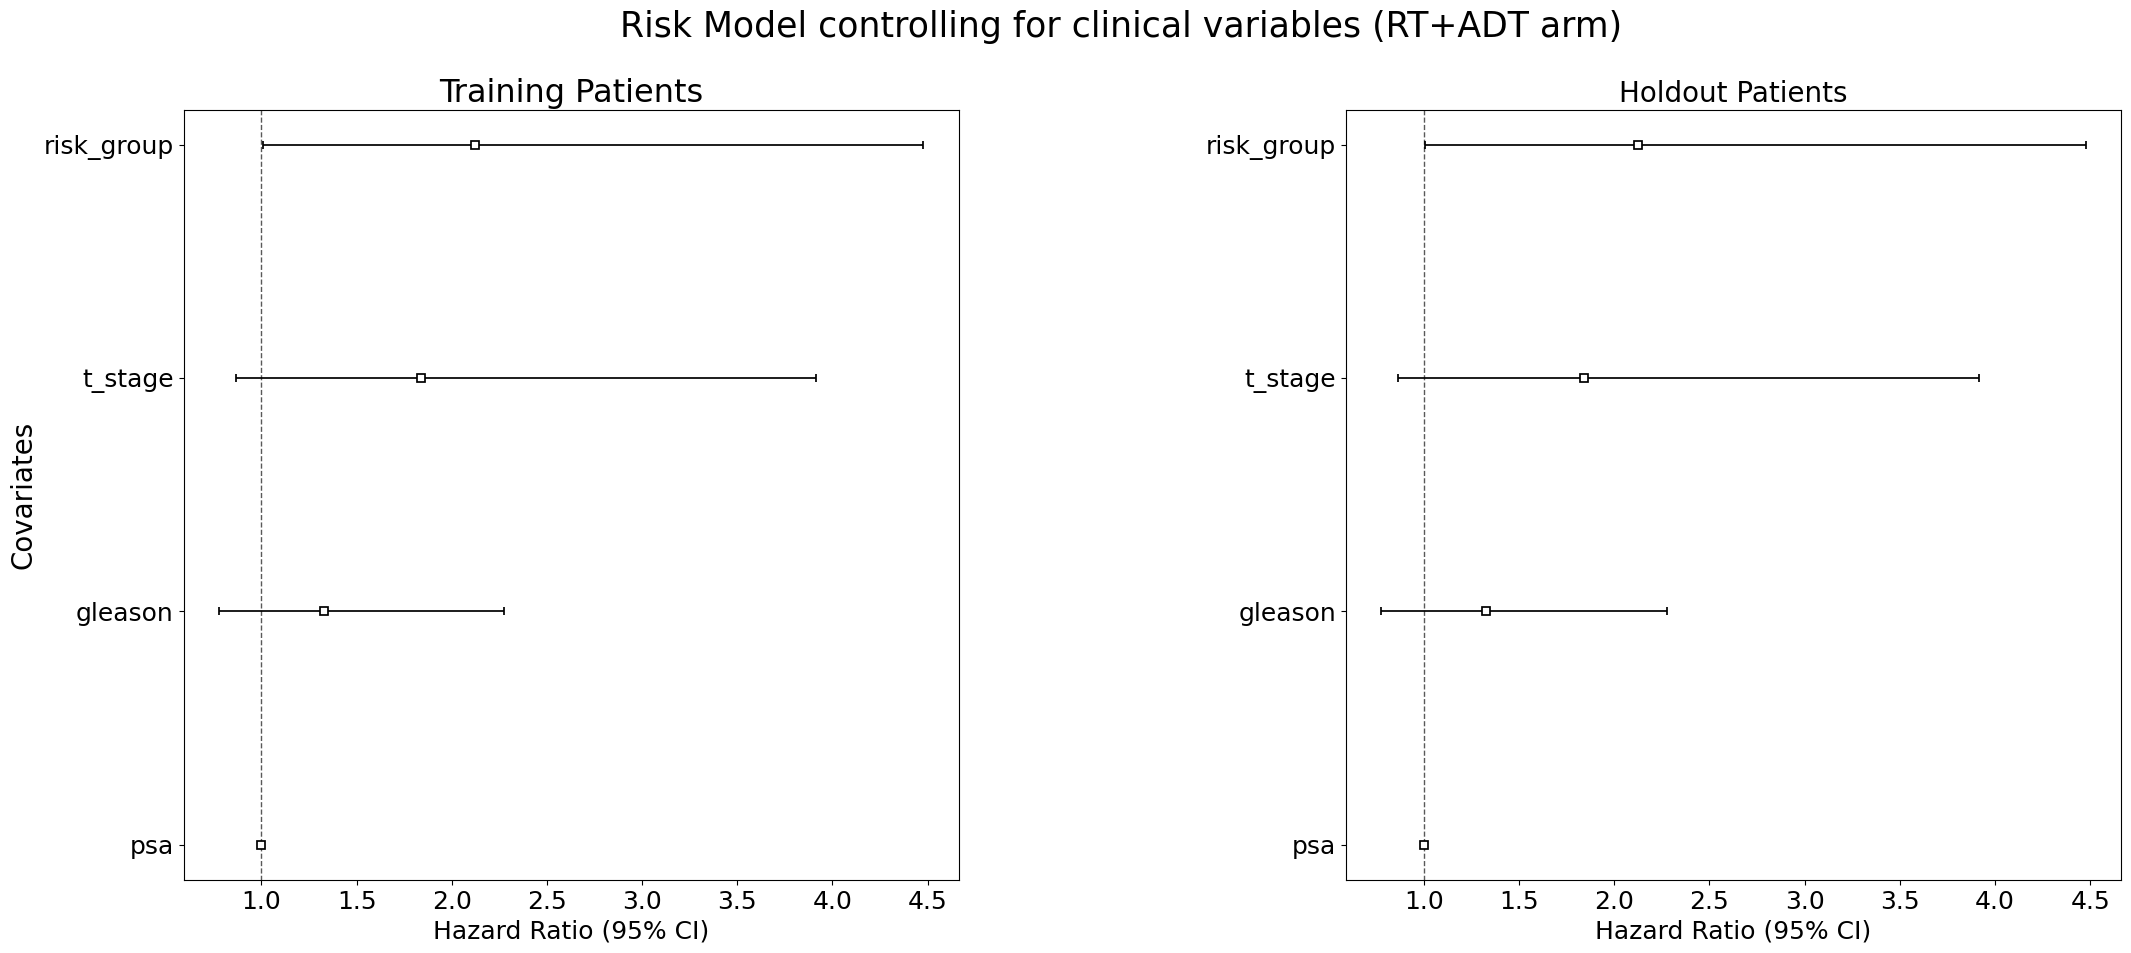

<lifelines.CoxPHFitter: fitted with 85 total observations, 56 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 29
   partial log-likelihood = -113.72
         time fit was run = 2024-05-20 20:21:41 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.75       2.12       0.38             0.01             1.50                 1.01                 4.48
gleason      0.28       1.33       0.27            -0.25             0.82                 0.78                 2.27
psa         -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
t_stage      0.61       1.84       0.38            -0.14             1.36                 0.87                 3.91

             cmp to     z    p   -log2(p)
covariate                                
risk_group     0.00  1.98 0.05       4.39
gleason        0.00  1.04 0.30       1.73
psa            0.00 -0.02 0.98       0.03
t_stage        0.00  1.59 0.11       3.15
---
Concordance = 0.66
Partial AIC = 235.44
log-likelihood ratio test = 8.04 on 4 df
-log2(p) of ll-ratio test = 3.47

In [106]:
holdout_results, cph_holdout_adjusted_risk = get_multivariate_coxph_results(multivar_analysis_df_no_chemo)
plt_title = 'Risk Model controlling for clinical variables (RT+ADT arm)'
save_path = ''
plot_n_save_adjusted_hazard(cph_holdout_adjusted_risk, cph_holdout_adjusted_risk, multivar_analysis_df_no_chemo, multivar_analysis_df_no_chemo, save_path, plt_title)
cph_holdout_adjusted_risk.print_summary()

In [107]:
results = {}
variables = ['risk_group','psa', 't_stage', 'gleason']
cph = CoxPHFitter()
for var in variables:

    cph.fit(multivar_analysis_all_patients[[var, 'time', 'event']], duration_col='time', event_col='event')
    
    # Extract the HR and its confidence intervals for the variable
    cph_model_results = cph.summary
    p = cph_model_results['p'].values[0]
    hr = cph_model_results['exp(coef)'].values[0]
    ci_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    ci_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    # Store the results
    results[var] = {'HR': hr, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper, 'p': p}

# Display the results
print("Univariate analysis all patients")
for var, stats in results.items():
    print(f"{var}: HR = {stats['HR']:.4f}, 95% CI = ({stats['95% CI Lower']:.4f}, {stats['95% CI Upper']:.4f}), p = {stats['p']:.6f}")

Univariate analysis all patients
risk_group: HR = 1.3675, 95% CI = (0.8866, 2.1092), p = 0.156847
psa: HR = 1.0001, 95% CI = (0.9927, 1.0076), p = 0.975678
t_stage: HR = 1.3658, 95% CI = (0.8709, 2.1420), p = 0.174454
gleason: HR = 1.4788, 95% CI = (1.1236, 1.9464), p = 0.005254


In [108]:
results = {}
variables = ['risk_group','psa', 't_stage', 'gleason']
cph = CoxPHFitter()
for var in variables:

    cph.fit(multivar_analysis_df_only_chemo[[var, 'time', 'event']], duration_col='time', event_col='event')
    
    # Extract the HR and its confidence intervals for the variable
    cph_model_results = cph.summary
    p = cph_model_results['p'].values[0]
    hr = cph_model_results['exp(coef)'].values[0]
    ci_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    ci_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    # Store the results
    results[var] = {'HR': hr, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper, 'p': p}

# Display the results
print("Univariate analysis CT patients")
for var, stats in results.items():
    print(f"{var}: HR = {stats['HR']:.4f}, 95% CI = ({stats['95% CI Lower']:.4f}, {stats['95% CI Upper']:.4f}), p = {stats['p']:.6f}")

Univariate analysis CT patients
risk_group: HR = 1.0469, 95% CI = (0.6095, 1.7984), p = 0.868001
psa: HR = 1.0003, 95% CI = (0.9909, 1.0098), p = 0.943545
t_stage: HR = 1.1517, 95% CI = (0.6553, 2.0243), p = 0.623448
gleason: HR = 1.5726, 95% CI = (1.1223, 2.2037), p = 0.008535


In [109]:
results = {}
variables = ['risk_group','psa', 't_stage', 'gleason']
cph = CoxPHFitter()
for var in variables:

    cph.fit(multivar_analysis_df_no_chemo[[var, 'time', 'event']], duration_col='time', event_col='event')
    
    # Extract the HR and its confidence intervals for the variable
    cph_model_results = cph.summary
    p = cph_model_results['p'].values[0]
    hr = cph_model_results['exp(coef)'].values[0]
    ci_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    ci_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    # Store the results
    results[var] = {'HR': hr, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper, 'p': p}

# Display the results
print("Univariate analysis no CT patients")
for var, stats in results.items():
    print(f"{var}: HR = {stats['HR']:.4f}, 95% CI = ({stats['95% CI Lower']:.4f}, {stats['95% CI Upper']:.4f}), p = {stats['p']:.6f}")

Univariate analysis no CT patients
risk_group: HR = 2.2118, 95% CI = (1.0523, 4.6488), p = 0.036214
psa: HR = 0.9987, 95% CI = (0.9868, 1.0107), p = 0.828210
t_stage: HR = 1.8945, 95% CI = (0.8943, 4.0133), p = 0.095234
gleason: HR = 1.3332, 95% CI = (0.8212, 2.1643), p = 0.244765
